# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for num_epochs epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Error')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('Accuracy')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102019 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f796076abe0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f796076abe0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f796076a130>)


In [3]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

# Setup hyperparameters
learning_rate = 0.001
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

### Print train and validation accuracy and error scores

In [4]:
def get_acc(stats, keys, hidden_dim):
    length = stats[:, keys["acc(train)"]].size

    return "Finished model accuracy\nTrain acc: " + str(stats[:, keys["acc(train)"]][length-1]) + "\nVal acc: " + str(stats[:, keys["acc(valid)"]][length-1]) + "\n"
    
def get_err(stats, keys, hidden_dim):
    length = stats[:, keys["error(train)"]].size

    return "Finished model error\nTrain err: " + str(stats[:, keys["error(train)"]][length-1]) + "\nVal err: " + str(stats[:, keys["error(valid)"]][length-1]) + "\n"
    
def get_all(stats, keys, hidden_dim):
    return get_acc(stats, keys, hidden_dim) + "\n\n" + get_err(stats, keys, hidden_dim)
    
def print_all(stats, keys, hidden_dim):
    print(get_acc(stats, keys, hidden_dim))
    print(get_err(stats, keys, hidden_dim))

### Save to file

In [10]:
import os

def write_txt_file(contents, file_name):
    dir_name = os.getcwd() + "/results/"
    
    with open(dir_name + file_name + ".txt", "w") as text_file:
        text_file.write(contents)
        
def write_npy_file(contents, file_name):
    dir_name = os.getcwd() + "/results/"
    
    with open(dir_name + file_name + ".npy", "wb") as text_file:
        np.save(text_file, contents)
        
def save_figure(fig, file_name):
    dir_name = os.getcwd() + "/results/" + file_name + ".svg"
    
    fig.savefig(dir_name)
    
def record_all(stats, keys, hidden_dim, fig_1, fig_2, file_prefix):
    print_all(stats, keys, hidden_dim)
    save_figure(fig_1, file_prefix + "-fig1")
    save_figure(fig_2, file_prefix + "-fig2")
    write_npy_file(stats, file_prefix + "-stats")
    write_txt_file(get_all(stats, keys, hidden_dim), file_prefix + "-summary")

# Q2

## 1 Hidden layer

Dimension: 32


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.8s to complete
    error(train)=1.21e+00, acc(train)=6.63e-01, error(valid)=1.22e+00, acc(valid)=6.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.8s to complete
    error(train)=1.08e+00, acc(train)=6.97e-01, error(valid)=1.10e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.8s to complete
    error(train)=9.98e-01, acc(train)=7.17e-01, error(valid)=1.02e+00, acc(valid)=7.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.8s to complete
    error(train)=9.60e-01, acc(train)=7.25e-01, error(valid)=9.88e-01, acc(valid)=7.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 0.8s to complete
    error(train)=9.08e-01, acc(train)=7.39e-01, error(valid)=9.41e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.9s to complete
    error(train)=8.90e-01, acc(train)=7.41e-01, error(valid)=9.29e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.9s to complete
    error(train)=8.64e-01, acc(train)=7.49e-01, error(valid)=9.01e-01, acc(valid)=7.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.8s to complete
    error(train)=8.38e-01, acc(train)=7.55e-01, error(valid)=8.81e-01, acc(valid)=7.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.8s to complete
    error(train)=8.23e-01, acc(train)=7.58e-01, error(valid)=8.67e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 0.9s to complete
    error(train)=8.09e-01, acc(train)=7.64e-01, error(valid)=8.60e-01, acc(valid)=7.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.9s to complete
    error(train)=7.93e-01, acc(train)=7.66e-01, error(valid)=8.47e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 0.9s to complete
    error(train)=7.90e-01, acc(train)=7.64e-01, error(valid)=8.45e-01, acc(valid)=7.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 0.8s to complete
    error(train)=7.68e-01, acc(train)=7.72e-01, error(valid)=8.24e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.0s to complete
    error(train)=7.62e-01, acc(train)=7.72e-01, error(valid)=8.20e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.8s to complete
    error(train)=7.57e-01, acc(train)=7.72e-01, error(valid)=8.17e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 0.9s to complete
    error(train)=7.42e-01, acc(train)=7.77e-01, error(valid)=8.08e-01, acc(valid)=7.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.8s to complete
    error(train)=7.37e-01, acc(train)=7.78e-01, error(valid)=8.02e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.9s to complete
    error(train)=7.24e-01, acc(train)=7.81e-01, error(valid)=7.93e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.9s to complete
    error(train)=7.15e-01, acc(train)=7.85e-01, error(valid)=7.84e-01, acc(valid)=7.67e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.9s to complete
    error(train)=7.21e-01, acc(train)=7.80e-01, error(valid)=7.91e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 0.8s to complete
    error(train)=7.02e-01, acc(train)=7.88e-01, error(valid)=7.73e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.9s to complete
    error(train)=7.07e-01, acc(train)=7.83e-01, error(valid)=7.81e-01, acc(valid)=7.67e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.9s to complete
    error(train)=6.95e-01, acc(train)=7.87e-01, error(valid)=7.72e-01, acc(valid)=7.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.9s to complete
    error(train)=6.89e-01, acc(train)=7.90e-01, error(valid)=7.67e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.9s to complete
    error(train)=6.81e-01, acc(train)=7.93e-01, error(valid)=7.60e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.8s to complete
    error(train)=6.78e-01, acc(train)=7.94e-01, error(valid)=7.58e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.9s to complete
    error(train)=6.77e-01, acc(train)=7.93e-01, error(valid)=7.60e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.9s to complete
    error(train)=6.68e-01, acc(train)=7.97e-01, error(valid)=7.53e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.9s to complete
    error(train)=6.73e-01, acc(train)=7.93e-01, error(valid)=7.58e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.9s to complete
    error(train)=6.66e-01, acc(train)=7.96e-01, error(valid)=7.54e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.0s to complete
    error(train)=6.63e-01, acc(train)=7.97e-01, error(valid)=7.54e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.0s to complete
    error(train)=6.70e-01, acc(train)=7.92e-01, error(valid)=7.60e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 0.9s to complete
    error(train)=6.57e-01, acc(train)=7.98e-01, error(valid)=7.48e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.9s to complete
    error(train)=6.61e-01, acc(train)=7.95e-01, error(valid)=7.54e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.9s to complete
    error(train)=6.57e-01, acc(train)=7.99e-01, error(valid)=7.49e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.1s to complete
    error(train)=6.51e-01, acc(train)=7.99e-01, error(valid)=7.47e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.0s to complete
    error(train)=6.45e-01, acc(train)=8.00e-01, error(valid)=7.42e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.0s to complete
    error(train)=6.46e-01, acc(train)=8.01e-01, error(valid)=7.40e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.0s to complete
    error(train)=6.43e-01, acc(train)=8.00e-01, error(valid)=7.40e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.9s to complete
    error(train)=6.49e-01, acc(train)=8.00e-01, error(valid)=7.49e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.9s to complete
    error(train)=6.44e-01, acc(train)=8.00e-01, error(valid)=7.44e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.0s to complete
    error(train)=6.43e-01, acc(train)=8.00e-01, error(valid)=7.42e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 0.9s to complete
    error(train)=6.40e-01, acc(train)=8.02e-01, error(valid)=7.40e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.9s to complete
    error(train)=6.34e-01, acc(train)=8.02e-01, error(valid)=7.35e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.9s to complete
    error(train)=6.33e-01, acc(train)=8.05e-01, error(valid)=7.38e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 0.9s to complete
    error(train)=6.34e-01, acc(train)=8.04e-01, error(valid)=7.34e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.9s to complete
    error(train)=6.28e-01, acc(train)=8.05e-01, error(valid)=7.33e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.0s to complete
    error(train)=6.29e-01, acc(train)=8.04e-01, error(valid)=7.35e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.9s to complete
    error(train)=6.28e-01, acc(train)=8.04e-01, error(valid)=7.36e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.9s to complete
    error(train)=6.17e-01, acc(train)=8.09e-01, error(valid)=7.25e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.8s to complete
    error(train)=6.20e-01, acc(train)=8.08e-01, error(valid)=7.27e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.9s to complete
    error(train)=6.31e-01, acc(train)=8.02e-01, error(valid)=7.38e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.1s to complete
    error(train)=6.22e-01, acc(train)=8.06e-01, error(valid)=7.32e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.9s to complete
    error(train)=6.23e-01, acc(train)=8.04e-01, error(valid)=7.38e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 0.9s to complete
    error(train)=6.14e-01, acc(train)=8.08e-01, error(valid)=7.26e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 0.9s to complete
    error(train)=6.14e-01, acc(train)=8.09e-01, error(valid)=7.27e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 0.9s to complete
    error(train)=6.11e-01, acc(train)=8.11e-01, error(valid)=7.24e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 0.9s to complete
    error(train)=6.15e-01, acc(train)=8.08e-01, error(valid)=7.33e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.9s to complete
    error(train)=6.17e-01, acc(train)=8.08e-01, error(valid)=7.35e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 0.8s to complete
    error(train)=6.13e-01, acc(train)=8.09e-01, error(valid)=7.33e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.8s to complete
    error(train)=6.14e-01, acc(train)=8.05e-01, error(valid)=7.31e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.8s to complete
    error(train)=6.05e-01, acc(train)=8.11e-01, error(valid)=7.20e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.8s to complete
    error(train)=6.07e-01, acc(train)=8.10e-01, error(valid)=7.27e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.8s to complete
    error(train)=6.10e-01, acc(train)=8.09e-01, error(valid)=7.30e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.9s to complete
    error(train)=6.08e-01, acc(train)=8.10e-01, error(valid)=7.29e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.9s to complete
    error(train)=6.03e-01, acc(train)=8.11e-01, error(valid)=7.24e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.8s to complete
    error(train)=6.08e-01, acc(train)=8.10e-01, error(valid)=7.36e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.9s to complete
    error(train)=6.02e-01, acc(train)=8.12e-01, error(valid)=7.26e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.8s to complete
    error(train)=5.97e-01, acc(train)=8.14e-01, error(valid)=7.23e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.8s to complete
    error(train)=6.02e-01, acc(train)=8.10e-01, error(valid)=7.30e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.8s to complete
    error(train)=6.05e-01, acc(train)=8.11e-01, error(valid)=7.33e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.9s to complete
    error(train)=5.97e-01, acc(train)=8.14e-01, error(valid)=7.23e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.8s to complete
    error(train)=5.94e-01, acc(train)=8.14e-01, error(valid)=7.24e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 0.9s to complete
    error(train)=5.96e-01, acc(train)=8.13e-01, error(valid)=7.25e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.9s to complete
    error(train)=6.02e-01, acc(train)=8.10e-01, error(valid)=7.35e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 0.9s to complete
    error(train)=6.02e-01, acc(train)=8.10e-01, error(valid)=7.34e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.9s to complete
    error(train)=6.00e-01, acc(train)=8.11e-01, error(valid)=7.32e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 0.9s to complete
    error(train)=5.96e-01, acc(train)=8.13e-01, error(valid)=7.28e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 0.9s to complete
    error(train)=5.94e-01, acc(train)=8.13e-01, error(valid)=7.24e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 0.9s to complete
    error(train)=5.97e-01, acc(train)=8.12e-01, error(valid)=7.32e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 0.9s to complete
    error(train)=5.94e-01, acc(train)=8.12e-01, error(valid)=7.29e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 0.9s to complete
    error(train)=5.89e-01, acc(train)=8.15e-01, error(valid)=7.27e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 0.9s to complete
    error(train)=5.88e-01, acc(train)=8.15e-01, error(valid)=7.23e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 0.9s to complete
    error(train)=5.92e-01, acc(train)=8.14e-01, error(valid)=7.32e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 0.9s to complete
    error(train)=5.88e-01, acc(train)=8.16e-01, error(valid)=7.26e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.0s to complete
    error(train)=5.90e-01, acc(train)=8.15e-01, error(valid)=7.31e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 0.9s to complete
    error(train)=5.89e-01, acc(train)=8.14e-01, error(valid)=7.30e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 0.9s to complete
    error(train)=5.87e-01, acc(train)=8.16e-01, error(valid)=7.26e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.9s to complete
    error(train)=5.92e-01, acc(train)=8.13e-01, error(valid)=7.39e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.0s to complete
    error(train)=5.88e-01, acc(train)=8.15e-01, error(valid)=7.29e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 0.9s to complete
    error(train)=5.82e-01, acc(train)=8.17e-01, error(valid)=7.25e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.9s to complete
    error(train)=5.88e-01, acc(train)=8.14e-01, error(valid)=7.34e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.9s to complete
    error(train)=5.84e-01, acc(train)=8.15e-01, error(valid)=7.31e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.9s to complete
    error(train)=5.89e-01, acc(train)=8.13e-01, error(valid)=7.35e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.1s to complete
    error(train)=5.79e-01, acc(train)=8.17e-01, error(valid)=7.22e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.9s to complete
    error(train)=5.91e-01, acc(train)=8.14e-01, error(valid)=7.39e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.0s to complete
    error(train)=5.81e-01, acc(train)=8.15e-01, error(valid)=7.24e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 0.9s to complete
    error(train)=5.83e-01, acc(train)=8.16e-01, error(valid)=7.33e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 0.9s to complete
    error(train)=5.85e-01, acc(train)=8.14e-01, error(valid)=7.29e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.1s to complete
    error(train)=5.84e-01, acc(train)=8.16e-01, error(valid)=7.32e-01, acc(valid)=7.79e-01


Finished model accuracy
Train acc: 0.816159999999999
Val acc: 0.7793670886075945

Finished model error
Train err: 0.5839604403660349
Val err: 0.7323329782068233

Dimension: 64


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.4s to complete
    error(train)=1.08e+00, acc(train)=6.90e-01, error(valid)=1.09e+00, acc(valid)=6.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.4s to complete
    error(train)=8.94e-01, acc(train)=7.40e-01, error(valid)=9.17e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.4s to complete
    error(train)=8.03e-01, acc(train)=7.65e-01, error(valid)=8.35e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.4s to complete
    error(train)=7.43e-01, acc(train)=7.77e-01, error(valid)=7.83e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.4s to complete
    error(train)=6.93e-01, acc(train)=7.91e-01, error(valid)=7.40e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.3s to complete
    error(train)=6.59e-01, acc(train)=7.98e-01, error(valid)=7.15e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.3s to complete
    error(train)=6.28e-01, acc(train)=8.04e-01, error(valid)=6.91e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.4s to complete
    error(train)=6.03e-01, acc(train)=8.14e-01, error(valid)=6.71e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.4s to complete
    error(train)=5.81e-01, acc(train)=8.18e-01, error(valid)=6.52e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.4s to complete
    error(train)=5.65e-01, acc(train)=8.22e-01, error(valid)=6.39e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.5s to complete
    error(train)=5.54e-01, acc(train)=8.25e-01, error(valid)=6.34e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.3s to complete
    error(train)=5.42e-01, acc(train)=8.29e-01, error(valid)=6.26e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.5s to complete
    error(train)=5.30e-01, acc(train)=8.34e-01, error(valid)=6.22e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.5s to complete
    error(train)=5.27e-01, acc(train)=8.27e-01, error(valid)=6.21e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.4s to complete
    error(train)=5.17e-01, acc(train)=8.34e-01, error(valid)=6.12e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.4s to complete
    error(train)=5.05e-01, acc(train)=8.38e-01, error(valid)=6.05e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.7s to complete
    error(train)=5.05e-01, acc(train)=8.37e-01, error(valid)=6.09e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.4s to complete
    error(train)=4.91e-01, acc(train)=8.43e-01, error(valid)=6.00e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.5s to complete
    error(train)=4.93e-01, acc(train)=8.39e-01, error(valid)=6.09e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.4s to complete
    error(train)=4.82e-01, acc(train)=8.43e-01, error(valid)=5.99e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.4s to complete
    error(train)=4.76e-01, acc(train)=8.46e-01, error(valid)=5.96e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.5s to complete
    error(train)=4.68e-01, acc(train)=8.48e-01, error(valid)=5.93e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.4s to complete
    error(train)=4.64e-01, acc(train)=8.50e-01, error(valid)=5.93e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.4s to complete
    error(train)=4.59e-01, acc(train)=8.50e-01, error(valid)=5.90e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.4s to complete
    error(train)=4.59e-01, acc(train)=8.50e-01, error(valid)=5.97e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.4s to complete
    error(train)=4.50e-01, acc(train)=8.52e-01, error(valid)=5.93e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.4s to complete
    error(train)=4.49e-01, acc(train)=8.52e-01, error(valid)=5.99e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.4s to complete
    error(train)=4.43e-01, acc(train)=8.53e-01, error(valid)=5.90e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.3s to complete
    error(train)=4.36e-01, acc(train)=8.56e-01, error(valid)=5.90e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.4s to complete
    error(train)=4.35e-01, acc(train)=8.57e-01, error(valid)=5.86e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.3s to complete
    error(train)=4.26e-01, acc(train)=8.59e-01, error(valid)=5.84e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.4s to complete
    error(train)=4.29e-01, acc(train)=8.57e-01, error(valid)=5.93e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.5s to complete
    error(train)=4.26e-01, acc(train)=8.58e-01, error(valid)=5.97e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.4s to complete
    error(train)=4.21e-01, acc(train)=8.61e-01, error(valid)=5.90e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.3s to complete
    error(train)=4.18e-01, acc(train)=8.60e-01, error(valid)=5.91e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.3s to complete
    error(train)=4.17e-01, acc(train)=8.61e-01, error(valid)=5.93e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.3s to complete
    error(train)=4.19e-01, acc(train)=8.59e-01, error(valid)=6.00e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.4s to complete
    error(train)=4.05e-01, acc(train)=8.66e-01, error(valid)=5.83e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.5s to complete
    error(train)=4.13e-01, acc(train)=8.61e-01, error(valid)=6.02e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.4s to complete
    error(train)=4.19e-01, acc(train)=8.57e-01, error(valid)=6.07e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.4s to complete
    error(train)=4.03e-01, acc(train)=8.65e-01, error(valid)=5.96e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.5s to complete
    error(train)=4.02e-01, acc(train)=8.65e-01, error(valid)=5.94e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.7s to complete
    error(train)=3.98e-01, acc(train)=8.66e-01, error(valid)=5.98e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.5s to complete
    error(train)=3.96e-01, acc(train)=8.66e-01, error(valid)=5.95e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.5s to complete
    error(train)=3.96e-01, acc(train)=8.67e-01, error(valid)=6.01e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.5s to complete
    error(train)=3.91e-01, acc(train)=8.67e-01, error(valid)=5.97e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.5s to complete
    error(train)=3.93e-01, acc(train)=8.68e-01, error(valid)=6.00e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.4s to complete
    error(train)=3.89e-01, acc(train)=8.68e-01, error(valid)=6.02e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.3s to complete
    error(train)=3.93e-01, acc(train)=8.67e-01, error(valid)=6.06e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.4s to complete
    error(train)=3.88e-01, acc(train)=8.70e-01, error(valid)=6.09e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.5s to complete
    error(train)=3.86e-01, acc(train)=8.70e-01, error(valid)=6.07e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.4s to complete
    error(train)=3.85e-01, acc(train)=8.70e-01, error(valid)=6.13e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.3s to complete
    error(train)=3.86e-01, acc(train)=8.69e-01, error(valid)=6.13e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.4s to complete
    error(train)=3.83e-01, acc(train)=8.70e-01, error(valid)=6.14e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.4s to complete
    error(train)=3.78e-01, acc(train)=8.70e-01, error(valid)=6.08e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.4s to complete
    error(train)=3.75e-01, acc(train)=8.71e-01, error(valid)=6.13e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.3s to complete
    error(train)=3.78e-01, acc(train)=8.72e-01, error(valid)=6.16e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.3s to complete
    error(train)=3.73e-01, acc(train)=8.73e-01, error(valid)=6.09e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.3s to complete
    error(train)=3.78e-01, acc(train)=8.70e-01, error(valid)=6.24e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.3s to complete
    error(train)=3.64e-01, acc(train)=8.76e-01, error(valid)=6.11e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.6s to complete
    error(train)=3.75e-01, acc(train)=8.71e-01, error(valid)=6.28e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.3s to complete
    error(train)=3.65e-01, acc(train)=8.75e-01, error(valid)=6.18e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.4s to complete
    error(train)=3.70e-01, acc(train)=8.72e-01, error(valid)=6.23e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.5s to complete
    error(train)=3.66e-01, acc(train)=8.76e-01, error(valid)=6.19e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.4s to complete
    error(train)=3.74e-01, acc(train)=8.71e-01, error(valid)=6.38e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.3s to complete
    error(train)=3.67e-01, acc(train)=8.73e-01, error(valid)=6.26e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.4s to complete
    error(train)=3.66e-01, acc(train)=8.73e-01, error(valid)=6.29e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.4s to complete
    error(train)=3.61e-01, acc(train)=8.76e-01, error(valid)=6.26e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.5s to complete
    error(train)=3.66e-01, acc(train)=8.75e-01, error(valid)=6.37e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.5s to complete
    error(train)=3.62e-01, acc(train)=8.73e-01, error(valid)=6.35e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.4s to complete
    error(train)=3.61e-01, acc(train)=8.76e-01, error(valid)=6.38e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.4s to complete
    error(train)=3.59e-01, acc(train)=8.77e-01, error(valid)=6.38e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.5s to complete
    error(train)=3.69e-01, acc(train)=8.72e-01, error(valid)=6.48e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.5s to complete
    error(train)=3.57e-01, acc(train)=8.76e-01, error(valid)=6.34e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.4s to complete
    error(train)=3.55e-01, acc(train)=8.78e-01, error(valid)=6.40e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.4s to complete
    error(train)=3.49e-01, acc(train)=8.80e-01, error(valid)=6.33e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.6s to complete
    error(train)=3.59e-01, acc(train)=8.76e-01, error(valid)=6.46e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.5s to complete
    error(train)=3.55e-01, acc(train)=8.77e-01, error(valid)=6.49e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.4s to complete
    error(train)=3.49e-01, acc(train)=8.79e-01, error(valid)=6.45e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.4s to complete
    error(train)=3.46e-01, acc(train)=8.81e-01, error(valid)=6.45e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.4s to complete
    error(train)=3.53e-01, acc(train)=8.77e-01, error(valid)=6.53e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.4s to complete
    error(train)=3.52e-01, acc(train)=8.79e-01, error(valid)=6.55e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.4s to complete
    error(train)=3.46e-01, acc(train)=8.80e-01, error(valid)=6.51e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.4s to complete
    error(train)=3.43e-01, acc(train)=8.82e-01, error(valid)=6.47e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.4s to complete
    error(train)=3.44e-01, acc(train)=8.81e-01, error(valid)=6.54e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.4s to complete
    error(train)=3.47e-01, acc(train)=8.79e-01, error(valid)=6.60e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.4s to complete
    error(train)=3.44e-01, acc(train)=8.81e-01, error(valid)=6.52e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.4s to complete
    error(train)=3.46e-01, acc(train)=8.78e-01, error(valid)=6.59e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.5s to complete
    error(train)=3.44e-01, acc(train)=8.80e-01, error(valid)=6.59e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.4s to complete
    error(train)=3.46e-01, acc(train)=8.79e-01, error(valid)=6.65e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.4s to complete
    error(train)=3.40e-01, acc(train)=8.82e-01, error(valid)=6.68e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.4s to complete
    error(train)=3.45e-01, acc(train)=8.80e-01, error(valid)=6.75e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.4s to complete
    error(train)=3.44e-01, acc(train)=8.80e-01, error(valid)=6.71e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.4s to complete
    error(train)=3.40e-01, acc(train)=8.82e-01, error(valid)=6.66e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.4s to complete
    error(train)=3.37e-01, acc(train)=8.83e-01, error(valid)=6.72e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.4s to complete
    error(train)=3.38e-01, acc(train)=8.82e-01, error(valid)=6.74e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.4s to complete
    error(train)=3.30e-01, acc(train)=8.86e-01, error(valid)=6.66e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.4s to complete
    error(train)=3.42e-01, acc(train)=8.81e-01, error(valid)=6.78e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.4s to complete
    error(train)=3.34e-01, acc(train)=8.84e-01, error(valid)=6.74e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.4s to complete
    error(train)=3.37e-01, acc(train)=8.82e-01, error(valid)=6.81e-01, acc(valid)=8.09e-01


Finished model accuracy
Train acc: 0.8819899999999979
Val acc: 0.8091139240506334

Finished model error
Train err: 0.3368447705573578
Val err: 0.6807286465396984

Dimension: 128


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.3s to complete
    error(train)=9.24e-01, acc(train)=7.32e-01, error(valid)=9.46e-01, acc(valid)=7.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.4s to complete
    error(train)=7.04e-01, acc(train)=7.89e-01, error(valid)=7.38e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.3s to complete
    error(train)=6.11e-01, acc(train)=8.12e-01, error(valid)=6.60e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.5s to complete
    error(train)=5.56e-01, acc(train)=8.26e-01, error(valid)=6.13e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.3s to complete
    error(train)=5.18e-01, acc(train)=8.35e-01, error(valid)=5.84e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.3s to complete
    error(train)=4.87e-01, acc(train)=8.42e-01, error(valid)=5.67e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.4s to complete
    error(train)=4.63e-01, acc(train)=8.49e-01, error(valid)=5.55e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.4s to complete
    error(train)=4.40e-01, acc(train)=8.55e-01, error(valid)=5.41e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.4s to complete
    error(train)=4.25e-01, acc(train)=8.58e-01, error(valid)=5.35e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.4s to complete
    error(train)=4.03e-01, acc(train)=8.66e-01, error(valid)=5.25e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.4s to complete
    error(train)=4.00e-01, acc(train)=8.63e-01, error(valid)=5.34e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.4s to complete
    error(train)=3.87e-01, acc(train)=8.69e-01, error(valid)=5.32e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.4s to complete
    error(train)=3.74e-01, acc(train)=8.73e-01, error(valid)=5.30e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.4s to complete
    error(train)=3.72e-01, acc(train)=8.72e-01, error(valid)=5.33e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.4s to complete
    error(train)=3.64e-01, acc(train)=8.75e-01, error(valid)=5.37e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.4s to complete
    error(train)=3.55e-01, acc(train)=8.76e-01, error(valid)=5.34e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.6s to complete
    error(train)=3.44e-01, acc(train)=8.81e-01, error(valid)=5.36e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.7s to complete
    error(train)=3.38e-01, acc(train)=8.83e-01, error(valid)=5.39e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.4s to complete
    error(train)=3.23e-01, acc(train)=8.88e-01, error(valid)=5.28e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.5s to complete
    error(train)=3.20e-01, acc(train)=8.89e-01, error(valid)=5.33e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.5s to complete
    error(train)=3.15e-01, acc(train)=8.90e-01, error(valid)=5.32e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.6s to complete
    error(train)=3.13e-01, acc(train)=8.89e-01, error(valid)=5.43e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.5s to complete
    error(train)=3.17e-01, acc(train)=8.87e-01, error(valid)=5.54e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.6s to complete
    error(train)=3.06e-01, acc(train)=8.90e-01, error(valid)=5.56e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.4s to complete
    error(train)=3.00e-01, acc(train)=8.94e-01, error(valid)=5.61e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.5s to complete
    error(train)=3.02e-01, acc(train)=8.90e-01, error(valid)=5.72e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.5s to complete
    error(train)=2.90e-01, acc(train)=8.97e-01, error(valid)=5.65e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.6s to complete
    error(train)=2.82e-01, acc(train)=9.00e-01, error(valid)=5.61e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.8s to complete
    error(train)=2.81e-01, acc(train)=9.00e-01, error(valid)=5.68e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.9s to complete
    error(train)=2.76e-01, acc(train)=8.99e-01, error(valid)=5.70e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.5s to complete
    error(train)=2.75e-01, acc(train)=9.02e-01, error(valid)=5.77e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.5s to complete
    error(train)=2.76e-01, acc(train)=8.99e-01, error(valid)=5.88e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.5s to complete
    error(train)=2.74e-01, acc(train)=9.03e-01, error(valid)=5.92e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.5s to complete
    error(train)=2.71e-01, acc(train)=9.02e-01, error(valid)=6.02e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.5s to complete
    error(train)=2.67e-01, acc(train)=9.02e-01, error(valid)=6.07e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.4s to complete
    error(train)=2.58e-01, acc(train)=9.07e-01, error(valid)=6.01e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.5s to complete
    error(train)=2.55e-01, acc(train)=9.08e-01, error(valid)=5.98e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.5s to complete
    error(train)=2.57e-01, acc(train)=9.07e-01, error(valid)=6.15e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.5s to complete
    error(train)=2.53e-01, acc(train)=9.07e-01, error(valid)=6.23e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.4s to complete
    error(train)=2.55e-01, acc(train)=9.06e-01, error(valid)=6.33e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.5s to complete
    error(train)=2.49e-01, acc(train)=9.09e-01, error(valid)=6.27e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.5s to complete
    error(train)=2.47e-01, acc(train)=9.08e-01, error(valid)=6.38e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.4s to complete
    error(train)=2.45e-01, acc(train)=9.11e-01, error(valid)=6.40e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.5s to complete
    error(train)=2.40e-01, acc(train)=9.11e-01, error(valid)=6.43e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.5s to complete
    error(train)=2.35e-01, acc(train)=9.14e-01, error(valid)=6.44e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.5s to complete
    error(train)=2.42e-01, acc(train)=9.11e-01, error(valid)=6.61e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.5s to complete
    error(train)=2.30e-01, acc(train)=9.17e-01, error(valid)=6.59e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.5s to complete
    error(train)=2.38e-01, acc(train)=9.13e-01, error(valid)=6.73e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.5s to complete
    error(train)=2.26e-01, acc(train)=9.17e-01, error(valid)=6.69e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.5s to complete
    error(train)=2.20e-01, acc(train)=9.20e-01, error(valid)=6.62e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.4s to complete
    error(train)=2.24e-01, acc(train)=9.18e-01, error(valid)=6.74e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.5s to complete
    error(train)=2.20e-01, acc(train)=9.19e-01, error(valid)=6.76e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.5s to complete
    error(train)=2.18e-01, acc(train)=9.20e-01, error(valid)=6.86e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.6s to complete
    error(train)=2.16e-01, acc(train)=9.20e-01, error(valid)=6.96e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.4s to complete
    error(train)=2.13e-01, acc(train)=9.21e-01, error(valid)=7.03e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.5s to complete
    error(train)=2.13e-01, acc(train)=9.20e-01, error(valid)=7.06e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.5s to complete
    error(train)=2.18e-01, acc(train)=9.19e-01, error(valid)=7.27e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.5s to complete
    error(train)=2.10e-01, acc(train)=9.22e-01, error(valid)=7.08e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.5s to complete
    error(train)=2.12e-01, acc(train)=9.21e-01, error(valid)=7.13e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.5s to complete
    error(train)=2.07e-01, acc(train)=9.23e-01, error(valid)=7.25e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.6s to complete
    error(train)=2.08e-01, acc(train)=9.22e-01, error(valid)=7.41e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.5s to complete
    error(train)=2.06e-01, acc(train)=9.22e-01, error(valid)=7.36e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.5s to complete
    error(train)=2.06e-01, acc(train)=9.22e-01, error(valid)=7.48e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.5s to complete
    error(train)=1.96e-01, acc(train)=9.27e-01, error(valid)=7.43e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.5s to complete
    error(train)=2.13e-01, acc(train)=9.18e-01, error(valid)=7.69e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.6s to complete
    error(train)=1.95e-01, acc(train)=9.27e-01, error(valid)=7.61e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.4s to complete
    error(train)=1.99e-01, acc(train)=9.25e-01, error(valid)=7.77e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.5s to complete
    error(train)=1.95e-01, acc(train)=9.27e-01, error(valid)=7.72e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.5s to complete
    error(train)=1.97e-01, acc(train)=9.25e-01, error(valid)=7.79e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.5s to complete
    error(train)=1.92e-01, acc(train)=9.29e-01, error(valid)=7.85e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.5s to complete
    error(train)=1.97e-01, acc(train)=9.26e-01, error(valid)=7.95e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.5s to complete
    error(train)=1.94e-01, acc(train)=9.27e-01, error(valid)=8.04e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.5s to complete
    error(train)=1.84e-01, acc(train)=9.32e-01, error(valid)=8.01e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.5s to complete
    error(train)=1.88e-01, acc(train)=9.28e-01, error(valid)=8.07e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.5s to complete
    error(train)=1.80e-01, acc(train)=9.33e-01, error(valid)=8.13e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.5s to complete
    error(train)=1.79e-01, acc(train)=9.32e-01, error(valid)=8.16e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.5s to complete
    error(train)=1.87e-01, acc(train)=9.30e-01, error(valid)=8.28e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.5s to complete
    error(train)=1.82e-01, acc(train)=9.31e-01, error(valid)=8.38e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.5s to complete
    error(train)=1.79e-01, acc(train)=9.33e-01, error(valid)=8.38e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.5s to complete
    error(train)=1.81e-01, acc(train)=9.30e-01, error(valid)=8.48e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.6s to complete
    error(train)=1.78e-01, acc(train)=9.34e-01, error(valid)=8.55e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.5s to complete
    error(train)=1.91e-01, acc(train)=9.23e-01, error(valid)=8.72e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.5s to complete
    error(train)=1.79e-01, acc(train)=9.31e-01, error(valid)=8.58e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.5s to complete
    error(train)=1.80e-01, acc(train)=9.31e-01, error(valid)=8.75e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.4s to complete
    error(train)=1.85e-01, acc(train)=9.29e-01, error(valid)=8.84e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.6s to complete
    error(train)=1.72e-01, acc(train)=9.35e-01, error(valid)=8.78e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.5s to complete
    error(train)=1.73e-01, acc(train)=9.34e-01, error(valid)=8.86e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.5s to complete
    error(train)=1.70e-01, acc(train)=9.35e-01, error(valid)=8.94e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.4s to complete
    error(train)=1.74e-01, acc(train)=9.33e-01, error(valid)=8.94e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.5s to complete
    error(train)=1.66e-01, acc(train)=9.36e-01, error(valid)=8.93e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.4s to complete
    error(train)=1.68e-01, acc(train)=9.36e-01, error(valid)=9.10e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.4s to complete
    error(train)=1.58e-01, acc(train)=9.40e-01, error(valid)=9.02e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.5s to complete
    error(train)=1.63e-01, acc(train)=9.39e-01, error(valid)=9.23e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.4s to complete
    error(train)=1.62e-01, acc(train)=9.38e-01, error(valid)=9.29e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.4s to complete
    error(train)=1.71e-01, acc(train)=9.35e-01, error(valid)=9.49e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.5s to complete
    error(train)=1.65e-01, acc(train)=9.37e-01, error(valid)=9.39e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.6s to complete
    error(train)=1.66e-01, acc(train)=9.36e-01, error(valid)=9.49e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.5s to complete
    error(train)=1.63e-01, acc(train)=9.36e-01, error(valid)=9.65e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.4s to complete
    error(train)=1.64e-01, acc(train)=9.37e-01, error(valid)=9.74e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.6s to complete
    error(train)=1.50e-01, acc(train)=9.43e-01, error(valid)=9.52e-01, acc(valid)=8.09e-01


Finished model accuracy
Train acc: 0.9433300000000043
Val acc: 0.8092405063291136

Finished model error
Train err: 0.14990213021218746
Val err: 0.9524715270678515



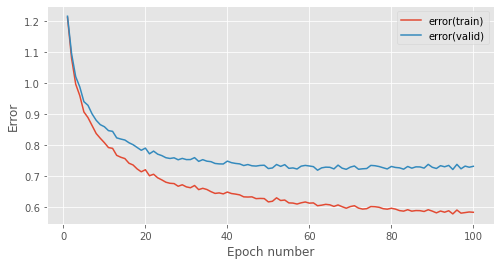

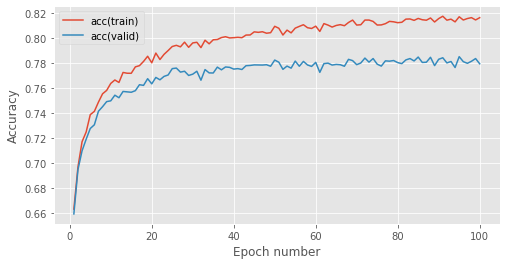

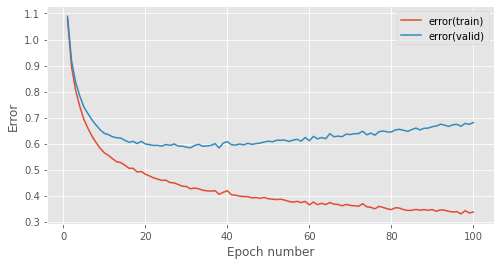

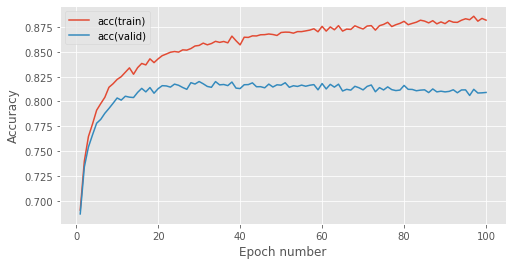

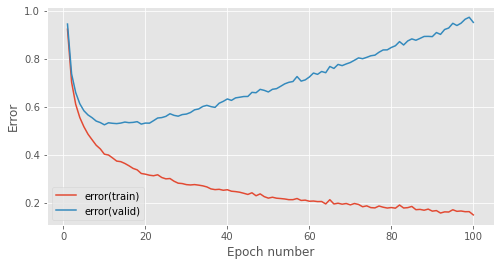

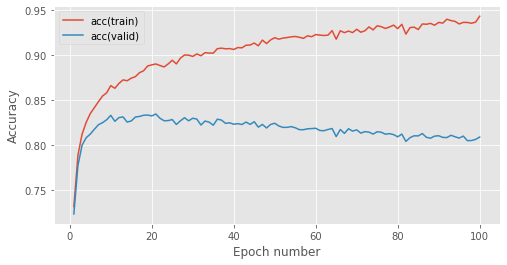

In [20]:
dims = [32, 64, 128]
input_dim, output_dim = 784, 47

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for hidden_dim in dims:
    print("Dimension: " + str(hidden_dim))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "q2-1layer-" + str(hidden_dim) + "units")

## 2 Hidden layers

Dimension: 64


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.9s to complete
    error(train)=9.47e-01, acc(train)=7.20e-01, error(valid)=9.68e-01, acc(valid)=7.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.9s to complete
    error(train)=7.53e-01, acc(train)=7.68e-01, error(valid)=7.89e-01, acc(valid)=7.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.9s to complete
    error(train)=6.72e-01, acc(train)=7.93e-01, error(valid)=7.17e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.9s to complete
    error(train)=6.25e-01, acc(train)=8.03e-01, error(valid)=6.77e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 0.9s to complete
    error(train)=5.80e-01, acc(train)=8.13e-01, error(valid)=6.44e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.9s to complete
    error(train)=5.51e-01, acc(train)=8.21e-01, error(valid)=6.23e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.9s to complete
    error(train)=5.21e-01, acc(train)=8.31e-01, error(valid)=6.03e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.9s to complete
    error(train)=5.11e-01, acc(train)=8.33e-01, error(valid)=5.96e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.9s to complete
    error(train)=4.94e-01, acc(train)=8.37e-01, error(valid)=5.93e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.1s to complete
    error(train)=4.71e-01, acc(train)=8.43e-01, error(valid)=5.76e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.9s to complete
    error(train)=4.64e-01, acc(train)=8.45e-01, error(valid)=5.76e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.0s to complete
    error(train)=4.50e-01, acc(train)=8.50e-01, error(valid)=5.66e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.0s to complete
    error(train)=4.55e-01, acc(train)=8.45e-01, error(valid)=5.79e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 0.9s to complete
    error(train)=4.30e-01, acc(train)=8.53e-01, error(valid)=5.55e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.9s to complete
    error(train)=4.23e-01, acc(train)=8.56e-01, error(valid)=5.61e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 0.9s to complete
    error(train)=4.22e-01, acc(train)=8.56e-01, error(valid)=5.61e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.9s to complete
    error(train)=4.11e-01, acc(train)=8.60e-01, error(valid)=5.57e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.9s to complete
    error(train)=4.06e-01, acc(train)=8.62e-01, error(valid)=5.58e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.9s to complete
    error(train)=3.94e-01, acc(train)=8.64e-01, error(valid)=5.49e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.9s to complete
    error(train)=3.89e-01, acc(train)=8.66e-01, error(valid)=5.56e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.0s to complete
    error(train)=3.76e-01, acc(train)=8.69e-01, error(valid)=5.45e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.9s to complete
    error(train)=3.79e-01, acc(train)=8.68e-01, error(valid)=5.59e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.9s to complete
    error(train)=3.68e-01, acc(train)=8.72e-01, error(valid)=5.49e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.9s to complete
    error(train)=3.65e-01, acc(train)=8.73e-01, error(valid)=5.53e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.9s to complete
    error(train)=3.69e-01, acc(train)=8.69e-01, error(valid)=5.61e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.9s to complete
    error(train)=3.63e-01, acc(train)=8.73e-01, error(valid)=5.58e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.9s to complete
    error(train)=3.60e-01, acc(train)=8.74e-01, error(valid)=5.62e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.9s to complete
    error(train)=3.52e-01, acc(train)=8.74e-01, error(valid)=5.61e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.9s to complete
    error(train)=3.61e-01, acc(train)=8.70e-01, error(valid)=5.71e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.9s to complete
    error(train)=3.58e-01, acc(train)=8.72e-01, error(valid)=5.81e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 0.9s to complete
    error(train)=3.50e-01, acc(train)=8.75e-01, error(valid)=5.70e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.0s to complete
    error(train)=3.45e-01, acc(train)=8.77e-01, error(valid)=5.71e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.0s to complete
    error(train)=3.39e-01, acc(train)=8.80e-01, error(valid)=5.63e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.9s to complete
    error(train)=3.35e-01, acc(train)=8.80e-01, error(valid)=5.75e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.9s to complete
    error(train)=3.32e-01, acc(train)=8.80e-01, error(valid)=5.71e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 0.9s to complete
    error(train)=3.37e-01, acc(train)=8.79e-01, error(valid)=5.84e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 0.9s to complete
    error(train)=3.23e-01, acc(train)=8.85e-01, error(valid)=5.73e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 0.9s to complete
    error(train)=3.16e-01, acc(train)=8.87e-01, error(valid)=5.73e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 0.9s to complete
    error(train)=3.24e-01, acc(train)=8.83e-01, error(valid)=5.92e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.9s to complete
    error(train)=3.15e-01, acc(train)=8.87e-01, error(valid)=5.84e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.9s to complete
    error(train)=3.12e-01, acc(train)=8.87e-01, error(valid)=5.86e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.0s to complete
    error(train)=3.13e-01, acc(train)=8.86e-01, error(valid)=5.95e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.0s to complete
    error(train)=3.16e-01, acc(train)=8.86e-01, error(valid)=6.04e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.9s to complete
    error(train)=3.11e-01, acc(train)=8.87e-01, error(valid)=6.00e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.9s to complete
    error(train)=3.07e-01, acc(train)=8.89e-01, error(valid)=6.03e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.0s to complete
    error(train)=3.16e-01, acc(train)=8.83e-01, error(valid)=6.11e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.9s to complete
    error(train)=3.06e-01, acc(train)=8.89e-01, error(valid)=6.11e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 0.9s to complete
    error(train)=2.95e-01, acc(train)=8.92e-01, error(valid)=5.99e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.9s to complete
    error(train)=2.96e-01, acc(train)=8.92e-01, error(valid)=6.09e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.9s to complete
    error(train)=2.97e-01, acc(train)=8.93e-01, error(valid)=6.11e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.9s to complete
    error(train)=3.00e-01, acc(train)=8.90e-01, error(valid)=6.17e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.9s to complete
    error(train)=3.15e-01, acc(train)=8.82e-01, error(valid)=6.34e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 0.9s to complete
    error(train)=3.06e-01, acc(train)=8.87e-01, error(valid)=6.39e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.9s to complete
    error(train)=2.90e-01, acc(train)=8.93e-01, error(valid)=6.27e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.0s to complete
    error(train)=2.94e-01, acc(train)=8.92e-01, error(valid)=6.40e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.0s to complete
    error(train)=2.87e-01, acc(train)=8.95e-01, error(valid)=6.31e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.0s to complete
    error(train)=2.98e-01, acc(train)=8.91e-01, error(valid)=6.45e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.0s to complete
    error(train)=2.93e-01, acc(train)=8.91e-01, error(valid)=6.64e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.9s to complete
    error(train)=2.85e-01, acc(train)=8.96e-01, error(valid)=6.50e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 0.9s to complete
    error(train)=2.90e-01, acc(train)=8.93e-01, error(valid)=6.61e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.9s to complete
    error(train)=2.90e-01, acc(train)=8.92e-01, error(valid)=6.60e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.9s to complete
    error(train)=2.79e-01, acc(train)=8.96e-01, error(valid)=6.60e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.9s to complete
    error(train)=2.79e-01, acc(train)=8.97e-01, error(valid)=6.51e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.9s to complete
    error(train)=2.70e-01, acc(train)=9.00e-01, error(valid)=6.51e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.9s to complete
    error(train)=2.84e-01, acc(train)=8.93e-01, error(valid)=6.75e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.9s to complete
    error(train)=2.81e-01, acc(train)=8.96e-01, error(valid)=6.82e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.9s to complete
    error(train)=2.83e-01, acc(train)=8.94e-01, error(valid)=6.78e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.9s to complete
    error(train)=2.78e-01, acc(train)=8.97e-01, error(valid)=6.84e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.9s to complete
    error(train)=2.82e-01, acc(train)=8.94e-01, error(valid)=6.94e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.9s to complete
    error(train)=2.81e-01, acc(train)=8.95e-01, error(valid)=6.81e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.9s to complete
    error(train)=2.81e-01, acc(train)=8.93e-01, error(valid)=7.01e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.9s to complete
    error(train)=2.72e-01, acc(train)=8.98e-01, error(valid)=6.94e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.9s to complete
    error(train)=2.74e-01, acc(train)=8.96e-01, error(valid)=6.93e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.0s to complete
    error(train)=2.61e-01, acc(train)=9.03e-01, error(valid)=6.86e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.9s to complete
    error(train)=2.65e-01, acc(train)=9.00e-01, error(valid)=6.97e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.0s to complete
    error(train)=2.65e-01, acc(train)=9.00e-01, error(valid)=7.01e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.9s to complete
    error(train)=2.72e-01, acc(train)=8.98e-01, error(valid)=7.16e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.0s to complete
    error(train)=2.59e-01, acc(train)=9.04e-01, error(valid)=6.98e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.0s to complete
    error(train)=2.63e-01, acc(train)=9.00e-01, error(valid)=7.11e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.0s to complete
    error(train)=2.61e-01, acc(train)=9.01e-01, error(valid)=7.15e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.0s to complete
    error(train)=2.64e-01, acc(train)=9.01e-01, error(valid)=7.25e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.0s to complete
    error(train)=2.54e-01, acc(train)=9.06e-01, error(valid)=7.09e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.0s to complete
    error(train)=2.66e-01, acc(train)=9.00e-01, error(valid)=7.31e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.0s to complete
    error(train)=2.68e-01, acc(train)=8.99e-01, error(valid)=7.31e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.0s to complete
    error(train)=2.70e-01, acc(train)=8.98e-01, error(valid)=7.41e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.0s to complete
    error(train)=2.59e-01, acc(train)=9.02e-01, error(valid)=7.29e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.0s to complete
    error(train)=2.57e-01, acc(train)=9.03e-01, error(valid)=7.28e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.0s to complete
    error(train)=2.64e-01, acc(train)=8.99e-01, error(valid)=7.47e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.9s to complete
    error(train)=2.54e-01, acc(train)=9.03e-01, error(valid)=7.39e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 0.9s to complete
    error(train)=2.59e-01, acc(train)=9.01e-01, error(valid)=7.50e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.0s to complete
    error(train)=2.51e-01, acc(train)=9.05e-01, error(valid)=7.50e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.9s to complete
    error(train)=2.49e-01, acc(train)=9.06e-01, error(valid)=7.53e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.9s to complete
    error(train)=2.55e-01, acc(train)=9.03e-01, error(valid)=7.64e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.9s to complete
    error(train)=2.55e-01, acc(train)=9.03e-01, error(valid)=7.75e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.0s to complete
    error(train)=2.56e-01, acc(train)=9.03e-01, error(valid)=7.64e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.9s to complete
    error(train)=2.50e-01, acc(train)=9.05e-01, error(valid)=7.70e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.0s to complete
    error(train)=2.51e-01, acc(train)=9.04e-01, error(valid)=7.76e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 0.9s to complete
    error(train)=2.48e-01, acc(train)=9.06e-01, error(valid)=7.80e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.0s to complete
    error(train)=2.44e-01, acc(train)=9.07e-01, error(valid)=7.84e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.0s to complete
    error(train)=2.41e-01, acc(train)=9.09e-01, error(valid)=7.86e-01, acc(valid)=8.09e-01


Finished model accuracy
Train acc: 0.9088699999999958
Val acc: 0.8093670886075948

Finished model error
Train err: 0.24088272156503243
Val err: 0.7858946488302053

Dimension: 128


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.3s to complete
    error(train)=7.49e-01, acc(train)=7.72e-01, error(valid)=7.70e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.4s to complete
    error(train)=5.79e-01, acc(train)=8.16e-01, error(valid)=6.20e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.5s to complete
    error(train)=5.03e-01, acc(train)=8.37e-01, error(valid)=5.65e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.4s to complete
    error(train)=4.54e-01, acc(train)=8.47e-01, error(valid)=5.28e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.4s to complete
    error(train)=4.28e-01, acc(train)=8.54e-01, error(valid)=5.23e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.5s to complete
    error(train)=4.06e-01, acc(train)=8.59e-01, error(valid)=5.14e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.5s to complete
    error(train)=3.76e-01, acc(train)=8.70e-01, error(valid)=5.05e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.5s to complete
    error(train)=3.58e-01, acc(train)=8.73e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.5s to complete
    error(train)=3.45e-01, acc(train)=8.78e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.5s to complete
    error(train)=3.24e-01, acc(train)=8.84e-01, error(valid)=4.93e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.5s to complete
    error(train)=3.17e-01, acc(train)=8.86e-01, error(valid)=5.08e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.5s to complete
    error(train)=3.01e-01, acc(train)=8.90e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.5s to complete
    error(train)=3.03e-01, acc(train)=8.89e-01, error(valid)=5.12e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.5s to complete
    error(train)=2.94e-01, acc(train)=8.91e-01, error(valid)=5.18e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.5s to complete
    error(train)=2.76e-01, acc(train)=8.97e-01, error(valid)=5.19e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.5s to complete
    error(train)=2.73e-01, acc(train)=8.95e-01, error(valid)=5.23e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.5s to complete
    error(train)=2.55e-01, acc(train)=9.05e-01, error(valid)=5.26e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.5s to complete
    error(train)=2.45e-01, acc(train)=9.08e-01, error(valid)=5.37e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.5s to complete
    error(train)=2.48e-01, acc(train)=9.03e-01, error(valid)=5.49e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.5s to complete
    error(train)=2.41e-01, acc(train)=9.07e-01, error(valid)=5.58e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.5s to complete
    error(train)=2.41e-01, acc(train)=9.06e-01, error(valid)=5.72e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.5s to complete
    error(train)=2.28e-01, acc(train)=9.12e-01, error(valid)=5.75e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.5s to complete
    error(train)=2.22e-01, acc(train)=9.15e-01, error(valid)=5.86e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.5s to complete
    error(train)=2.17e-01, acc(train)=9.14e-01, error(valid)=6.00e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.5s to complete
    error(train)=2.11e-01, acc(train)=9.17e-01, error(valid)=5.94e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.5s to complete
    error(train)=2.10e-01, acc(train)=9.18e-01, error(valid)=6.18e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.5s to complete
    error(train)=2.04e-01, acc(train)=9.18e-01, error(valid)=6.14e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.5s to complete
    error(train)=2.16e-01, acc(train)=9.14e-01, error(valid)=6.39e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.5s to complete
    error(train)=2.03e-01, acc(train)=9.19e-01, error(valid)=6.56e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.5s to complete
    error(train)=1.94e-01, acc(train)=9.23e-01, error(valid)=6.56e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.5s to complete
    error(train)=1.90e-01, acc(train)=9.25e-01, error(valid)=6.74e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.5s to complete
    error(train)=1.88e-01, acc(train)=9.25e-01, error(valid)=6.84e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.5s to complete
    error(train)=1.86e-01, acc(train)=9.24e-01, error(valid)=6.98e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.5s to complete
    error(train)=1.73e-01, acc(train)=9.30e-01, error(valid)=6.97e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.6s to complete
    error(train)=1.80e-01, acc(train)=9.28e-01, error(valid)=7.28e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.5s to complete
    error(train)=1.73e-01, acc(train)=9.30e-01, error(valid)=7.31e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.5s to complete
    error(train)=1.90e-01, acc(train)=9.24e-01, error(valid)=7.54e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.5s to complete
    error(train)=1.63e-01, acc(train)=9.35e-01, error(valid)=7.47e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.5s to complete
    error(train)=1.70e-01, acc(train)=9.30e-01, error(valid)=7.68e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.5s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=7.64e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.5s to complete
    error(train)=1.61e-01, acc(train)=9.34e-01, error(valid)=7.97e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.5s to complete
    error(train)=1.77e-01, acc(train)=9.28e-01, error(valid)=8.20e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.5s to complete
    error(train)=1.63e-01, acc(train)=9.33e-01, error(valid)=8.25e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.5s to complete
    error(train)=1.53e-01, acc(train)=9.38e-01, error(valid)=8.19e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.5s to complete
    error(train)=1.51e-01, acc(train)=9.38e-01, error(valid)=8.29e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.5s to complete
    error(train)=1.57e-01, acc(train)=9.36e-01, error(valid)=8.62e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.5s to complete
    error(train)=1.52e-01, acc(train)=9.38e-01, error(valid)=8.55e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.5s to complete
    error(train)=1.46e-01, acc(train)=9.40e-01, error(valid)=8.89e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.5s to complete
    error(train)=1.47e-01, acc(train)=9.40e-01, error(valid)=8.90e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.5s to complete
    error(train)=1.48e-01, acc(train)=9.40e-01, error(valid)=9.04e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.5s to complete
    error(train)=1.26e-01, acc(train)=9.49e-01, error(valid)=8.92e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.5s to complete
    error(train)=1.36e-01, acc(train)=9.44e-01, error(valid)=9.21e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.5s to complete
    error(train)=1.35e-01, acc(train)=9.44e-01, error(valid)=9.44e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.5s to complete
    error(train)=1.45e-01, acc(train)=9.40e-01, error(valid)=9.86e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.5s to complete
    error(train)=1.42e-01, acc(train)=9.42e-01, error(valid)=9.63e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.6s to complete
    error(train)=1.44e-01, acc(train)=9.42e-01, error(valid)=1.01e+00, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.6s to complete
    error(train)=1.35e-01, acc(train)=9.44e-01, error(valid)=9.99e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.6s to complete
    error(train)=1.31e-01, acc(train)=9.46e-01, error(valid)=1.01e+00, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.6s to complete
    error(train)=1.20e-01, acc(train)=9.51e-01, error(valid)=1.01e+00, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.6s to complete
    error(train)=1.29e-01, acc(train)=9.47e-01, error(valid)=1.04e+00, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.6s to complete
    error(train)=1.35e-01, acc(train)=9.45e-01, error(valid)=1.06e+00, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.6s to complete
    error(train)=1.33e-01, acc(train)=9.45e-01, error(valid)=1.09e+00, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.6s to complete
    error(train)=1.42e-01, acc(train)=9.42e-01, error(valid)=1.11e+00, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.6s to complete
    error(train)=1.24e-01, acc(train)=9.49e-01, error(valid)=1.09e+00, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.6s to complete
    error(train)=1.26e-01, acc(train)=9.48e-01, error(valid)=1.13e+00, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.6s to complete
    error(train)=1.23e-01, acc(train)=9.49e-01, error(valid)=1.12e+00, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.5s to complete
    error(train)=1.30e-01, acc(train)=9.45e-01, error(valid)=1.14e+00, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.5s to complete
    error(train)=1.18e-01, acc(train)=9.52e-01, error(valid)=1.15e+00, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.5s to complete
    error(train)=1.24e-01, acc(train)=9.49e-01, error(valid)=1.16e+00, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.5s to complete
    error(train)=1.18e-01, acc(train)=9.50e-01, error(valid)=1.17e+00, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.5s to complete
    error(train)=1.14e-01, acc(train)=9.53e-01, error(valid)=1.17e+00, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.5s to complete
    error(train)=1.20e-01, acc(train)=9.51e-01, error(valid)=1.22e+00, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.5s to complete
    error(train)=1.32e-01, acc(train)=9.48e-01, error(valid)=1.23e+00, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.5s to complete
    error(train)=1.20e-01, acc(train)=9.52e-01, error(valid)=1.24e+00, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.5s to complete
    error(train)=1.24e-01, acc(train)=9.52e-01, error(valid)=1.28e+00, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.5s to complete
    error(train)=1.07e-01, acc(train)=9.56e-01, error(valid)=1.29e+00, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.5s to complete
    error(train)=1.19e-01, acc(train)=9.52e-01, error(valid)=1.30e+00, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.5s to complete
    error(train)=1.30e-01, acc(train)=9.45e-01, error(valid)=1.33e+00, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.5s to complete
    error(train)=1.13e-01, acc(train)=9.54e-01, error(valid)=1.29e+00, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.5s to complete
    error(train)=1.06e-01, acc(train)=9.56e-01, error(valid)=1.31e+00, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.5s to complete
    error(train)=1.10e-01, acc(train)=9.55e-01, error(valid)=1.29e+00, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.5s to complete
    error(train)=1.07e-01, acc(train)=9.56e-01, error(valid)=1.32e+00, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.5s to complete
    error(train)=1.18e-01, acc(train)=9.54e-01, error(valid)=1.37e+00, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.5s to complete
    error(train)=1.13e-01, acc(train)=9.52e-01, error(valid)=1.37e+00, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.6s to complete
    error(train)=1.18e-01, acc(train)=9.52e-01, error(valid)=1.40e+00, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.5s to complete
    error(train)=1.04e-01, acc(train)=9.57e-01, error(valid)=1.41e+00, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.5s to complete
    error(train)=1.11e-01, acc(train)=9.54e-01, error(valid)=1.39e+00, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.5s to complete
    error(train)=1.15e-01, acc(train)=9.53e-01, error(valid)=1.44e+00, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.5s to complete
    error(train)=1.06e-01, acc(train)=9.57e-01, error(valid)=1.44e+00, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.5s to complete
    error(train)=1.29e-01, acc(train)=9.49e-01, error(valid)=1.50e+00, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.5s to complete
    error(train)=1.02e-01, acc(train)=9.59e-01, error(valid)=1.43e+00, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.5s to complete
    error(train)=1.16e-01, acc(train)=9.53e-01, error(valid)=1.49e+00, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.5s to complete
    error(train)=9.78e-02, acc(train)=9.60e-01, error(valid)=1.49e+00, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.5s to complete
    error(train)=1.04e-01, acc(train)=9.57e-01, error(valid)=1.49e+00, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.5s to complete
    error(train)=1.07e-01, acc(train)=9.57e-01, error(valid)=1.52e+00, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.5s to complete
    error(train)=9.24e-02, acc(train)=9.62e-01, error(valid)=1.49e+00, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.5s to complete
    error(train)=9.03e-02, acc(train)=9.63e-01, error(valid)=1.52e+00, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.5s to complete
    error(train)=1.07e-01, acc(train)=9.56e-01, error(valid)=1.55e+00, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.5s to complete
    error(train)=1.14e-01, acc(train)=9.55e-01, error(valid)=1.56e+00, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.5s to complete
    error(train)=1.07e-01, acc(train)=9.56e-01, error(valid)=1.56e+00, acc(valid)=8.16e-01


Finished model accuracy
Train acc: 0.9556200000000098
Val acc: 0.8155696202531643

Finished model error
Train err: 0.10701313749122243
Val err: 1.562835546092201



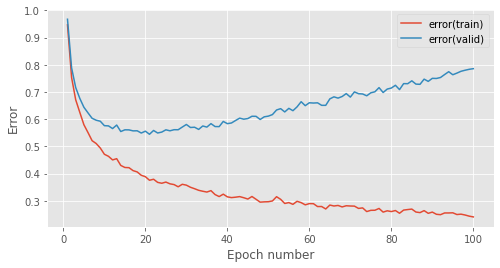

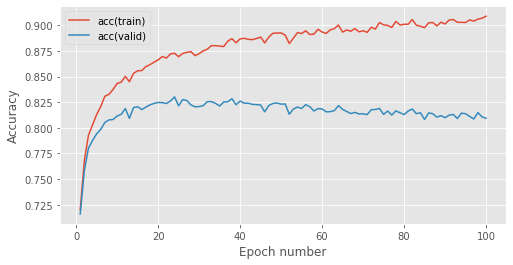

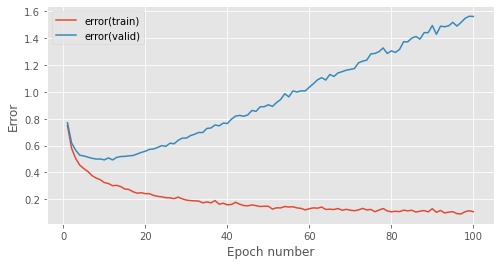

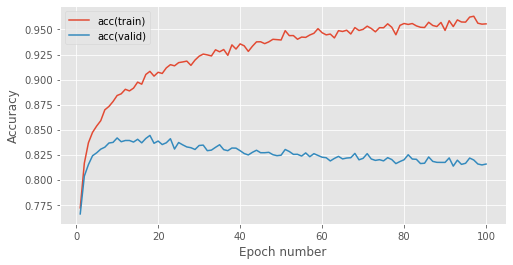

In [9]:
dims = [32, 64, 128]
input_dim, output_dim = 784, 47

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for hidden_dim in dims:
    print("Dimension: " + str(hidden_dim))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # second hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "q2/q2-2layers-" + str(hidden_dim) + "units")

## 3 Hidden layers

In [ ]:
dims = [32, 64, 128]
input_dim, output_dim = 784, 47

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for hidden_dim in dims:
    print("Dimension: " + str(hidden_dim))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # second hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # third hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "q2/q2-3layers-" + str(hidden_dim) + "units")

Dimension: 32


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.7s to complete
    error(train)=1.16e+00, acc(train)=6.67e-01, error(valid)=1.17e+00, acc(valid)=6.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.7s to complete
    error(train)=9.63e-01, acc(train)=7.14e-01, error(valid)=9.77e-01, acc(valid)=7.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.7s to complete
    error(train)=8.67e-01, acc(train)=7.40e-01, error(valid)=8.90e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.7s to complete
    error(train)=8.06e-01, acc(train)=7.56e-01, error(valid)=8.34e-01, acc(valid)=7.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 0.7s to complete
    error(train)=7.81e-01, acc(train)=7.62e-01, error(valid)=8.10e-01, acc(valid)=7.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.7s to complete
    error(train)=7.45e-01, acc(train)=7.72e-01, error(valid)=7.81e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.7s to complete
    error(train)=7.01e-01, acc(train)=7.83e-01, error(valid)=7.40e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.7s to complete
    error(train)=6.94e-01, acc(train)=7.81e-01, error(valid)=7.43e-01, acc(valid)=7.67e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.7s to complete
    error(train)=6.77e-01, acc(train)=7.85e-01, error(valid)=7.26e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 0.7s to complete
    error(train)=6.63e-01, acc(train)=7.92e-01, error(valid)=7.17e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.7s to complete
    error(train)=6.56e-01, acc(train)=7.92e-01, error(valid)=7.10e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 0.7s to complete
    error(train)=6.46e-01, acc(train)=7.96e-01, error(valid)=7.00e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 0.7s to complete
    error(train)=6.23e-01, acc(train)=8.03e-01, error(valid)=6.82e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 0.7s to complete
    error(train)=6.13e-01, acc(train)=8.05e-01, error(valid)=6.73e-01, acc(valid)=7.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.7s to complete
    error(train)=6.17e-01, acc(train)=7.99e-01, error(valid)=6.82e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 0.7s to complete
    error(train)=6.18e-01, acc(train)=8.01e-01, error(valid)=6.84e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.8s to complete
    error(train)=6.17e-01, acc(train)=8.02e-01, error(valid)=6.82e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.8s to complete
    error(train)=5.82e-01, acc(train)=8.13e-01, error(valid)=6.48e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.7s to complete
    error(train)=5.78e-01, acc(train)=8.14e-01, error(valid)=6.50e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.7s to complete
    error(train)=5.76e-01, acc(train)=8.15e-01, error(valid)=6.52e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 0.7s to complete
    error(train)=5.80e-01, acc(train)=8.11e-01, error(valid)=6.61e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.7s to complete
    error(train)=5.75e-01, acc(train)=8.12e-01, error(valid)=6.55e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.7s to complete
    error(train)=5.70e-01, acc(train)=8.15e-01, error(valid)=6.53e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.7s to complete
    error(train)=5.67e-01, acc(train)=8.16e-01, error(valid)=6.54e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.8s to complete
    error(train)=5.59e-01, acc(train)=8.18e-01, error(valid)=6.46e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.7s to complete
    error(train)=5.55e-01, acc(train)=8.19e-01, error(valid)=6.47e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.8s to complete
    error(train)=5.52e-01, acc(train)=8.21e-01, error(valid)=6.43e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.7s to complete
    error(train)=5.42e-01, acc(train)=8.23e-01, error(valid)=6.37e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.7s to complete
    error(train)=5.47e-01, acc(train)=8.21e-01, error(valid)=6.45e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.7s to complete
    error(train)=5.41e-01, acc(train)=8.25e-01, error(valid)=6.41e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 0.7s to complete
    error(train)=5.37e-01, acc(train)=8.26e-01, error(valid)=6.42e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 0.7s to complete
    error(train)=5.36e-01, acc(train)=8.26e-01, error(valid)=6.41e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 0.7s to complete
    error(train)=5.31e-01, acc(train)=8.26e-01, error(valid)=6.38e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.8s to complete
    error(train)=5.49e-01, acc(train)=8.18e-01, error(valid)=6.54e-01, acc(valid)=7.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.7s to complete
    error(train)=5.31e-01, acc(train)=8.25e-01, error(valid)=6.47e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 0.7s to complete
    error(train)=5.33e-01, acc(train)=8.25e-01, error(valid)=6.42e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 0.7s to complete
    error(train)=5.21e-01, acc(train)=8.29e-01, error(valid)=6.36e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 0.7s to complete
    error(train)=5.22e-01, acc(train)=8.28e-01, error(valid)=6.38e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 0.7s to complete
    error(train)=5.24e-01, acc(train)=8.28e-01, error(valid)=6.41e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.7s to complete
    error(train)=5.22e-01, acc(train)=8.29e-01, error(valid)=6.39e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.7s to complete
    error(train)=5.29e-01, acc(train)=8.24e-01, error(valid)=6.52e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 0.8s to complete
    error(train)=5.08e-01, acc(train)=8.32e-01, error(valid)=6.27e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 0.7s to complete
    error(train)=5.23e-01, acc(train)=8.26e-01, error(valid)=6.44e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.7s to complete
    error(train)=5.10e-01, acc(train)=8.33e-01, error(valid)=6.38e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.7s to complete
    error(train)=5.15e-01, acc(train)=8.27e-01, error(valid)=6.47e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 0.7s to complete
    error(train)=5.12e-01, acc(train)=8.30e-01, error(valid)=6.38e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.7s to complete
    error(train)=5.04e-01, acc(train)=8.33e-01, error(valid)=6.36e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 0.7s to complete
    error(train)=5.10e-01, acc(train)=8.29e-01, error(valid)=6.42e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.8s to complete
    error(train)=5.08e-01, acc(train)=8.29e-01, error(valid)=6.40e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.8s to complete
    error(train)=5.05e-01, acc(train)=8.34e-01, error(valid)=6.36e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.7s to complete
    error(train)=5.04e-01, acc(train)=8.34e-01, error(valid)=6.41e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.7s to complete
    error(train)=4.98e-01, acc(train)=8.36e-01, error(valid)=6.33e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 0.7s to complete
    error(train)=5.00e-01, acc(train)=8.33e-01, error(valid)=6.40e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.7s to complete
    error(train)=4.96e-01, acc(train)=8.36e-01, error(valid)=6.34e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 0.7s to complete
    error(train)=4.91e-01, acc(train)=8.37e-01, error(valid)=6.27e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 0.7s to complete
    error(train)=4.89e-01, acc(train)=8.37e-01, error(valid)=6.27e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 0.7s to complete
    error(train)=4.96e-01, acc(train)=8.32e-01, error(valid)=6.46e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 0.8s to complete
    error(train)=4.90e-01, acc(train)=8.38e-01, error(valid)=6.33e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.7s to complete
    error(train)=4.89e-01, acc(train)=8.37e-01, error(valid)=6.34e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 0.7s to complete
    error(train)=4.84e-01, acc(train)=8.40e-01, error(valid)=6.32e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.7s to complete
    error(train)=4.98e-01, acc(train)=8.34e-01, error(valid)=6.44e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.7s to complete
    error(train)=4.90e-01, acc(train)=8.35e-01, error(valid)=6.40e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.7s to complete
    error(train)=4.83e-01, acc(train)=8.37e-01, error(valid)=6.39e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.7s to complete
    error(train)=4.92e-01, acc(train)=8.35e-01, error(valid)=6.41e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.8s to complete
    error(train)=4.88e-01, acc(train)=8.36e-01, error(valid)=6.39e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.7s to complete
    error(train)=4.73e-01, acc(train)=8.42e-01, error(valid)=6.28e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.8s to complete
    error(train)=4.81e-01, acc(train)=8.39e-01, error(valid)=6.35e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.7s to complete
    error(train)=4.69e-01, acc(train)=8.42e-01, error(valid)=6.27e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.8s to complete
    error(train)=4.84e-01, acc(train)=8.38e-01, error(valid)=6.45e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.7s to complete
    error(train)=4.84e-01, acc(train)=8.38e-01, error(valid)=6.45e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.7s to complete
    error(train)=4.83e-01, acc(train)=8.36e-01, error(valid)=6.47e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.7s to complete
    error(train)=4.71e-01, acc(train)=8.40e-01, error(valid)=6.35e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.7s to complete
    error(train)=4.77e-01, acc(train)=8.39e-01, error(valid)=6.38e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 0.7s to complete
    error(train)=4.74e-01, acc(train)=8.40e-01, error(valid)=6.35e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.7s to complete
    error(train)=4.77e-01, acc(train)=8.38e-01, error(valid)=6.39e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 0.7s to complete
    error(train)=4.72e-01, acc(train)=8.42e-01, error(valid)=6.43e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.8s to complete
    error(train)=4.64e-01, acc(train)=8.45e-01, error(valid)=6.31e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 0.7s to complete
    error(train)=4.80e-01, acc(train)=8.38e-01, error(valid)=6.42e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 0.7s to complete
    error(train)=4.75e-01, acc(train)=8.37e-01, error(valid)=6.43e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 0.7s to complete
    error(train)=4.63e-01, acc(train)=8.44e-01, error(valid)=6.34e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 0.8s to complete
    error(train)=4.62e-01, acc(train)=8.45e-01, error(valid)=6.40e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 0.7s to complete
    error(train)=4.63e-01, acc(train)=8.43e-01, error(valid)=6.34e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 0.7s to complete
    error(train)=4.70e-01, acc(train)=8.39e-01, error(valid)=6.45e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 0.7s to complete
    error(train)=4.61e-01, acc(train)=8.43e-01, error(valid)=6.34e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 0.7s to complete
    error(train)=4.63e-01, acc(train)=8.43e-01, error(valid)=6.38e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 0.7s to complete
    error(train)=4.62e-01, acc(train)=8.44e-01, error(valid)=6.39e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 0.8s to complete
    error(train)=4.60e-01, acc(train)=8.44e-01, error(valid)=6.35e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 0.7s to complete
    error(train)=4.62e-01, acc(train)=8.44e-01, error(valid)=6.40e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.8s to complete
    error(train)=4.61e-01, acc(train)=8.44e-01, error(valid)=6.39e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 0.8s to complete
    error(train)=4.73e-01, acc(train)=8.41e-01, error(valid)=6.51e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 0.8s to complete
    error(train)=4.56e-01, acc(train)=8.45e-01, error(valid)=6.37e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.7s to complete
    error(train)=4.63e-01, acc(train)=8.43e-01, error(valid)=6.44e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.7s to complete
    error(train)=4.60e-01, acc(train)=8.44e-01, error(valid)=6.39e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.7s to complete
    error(train)=4.56e-01, acc(train)=8.45e-01, error(valid)=6.41e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 0.7s to complete
    error(train)=4.55e-01, acc(train)=8.44e-01, error(valid)=6.41e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.7s to complete
    error(train)=4.56e-01, acc(train)=8.45e-01, error(valid)=6.48e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 0.7s to complete
    error(train)=4.52e-01, acc(train)=8.45e-01, error(valid)=6.43e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 0.7s to complete
    error(train)=4.46e-01, acc(train)=8.48e-01, error(valid)=6.35e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 0.7s to complete
    error(train)=4.52e-01, acc(train)=8.46e-01, error(valid)=6.41e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 0.7s to complete
    error(train)=4.50e-01, acc(train)=8.46e-01, error(valid)=6.43e-01, acc(valid)=8.00e-01


Finished model accuracy
Train acc: 0.845930000000002
Val acc: 0.8000632911392404

Finished model error
Train err: 0.44953492677640494
Val err: 0.6432261403841051

Dimension: 64


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.0s to complete
    error(train)=9.08e-01, acc(train)=7.25e-01, error(valid)=9.27e-01, acc(valid)=7.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.0s to complete
    error(train)=7.01e-01, acc(train)=7.81e-01, error(valid)=7.38e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.0s to complete
    error(train)=6.32e-01, acc(train)=7.99e-01, error(valid)=6.77e-01, acc(valid)=7.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.0s to complete
    error(train)=5.99e-01, acc(train)=8.01e-01, error(valid)=6.57e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.0s to complete
    error(train)=5.40e-01, acc(train)=8.21e-01, error(valid)=6.03e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.0s to complete
    error(train)=5.25e-01, acc(train)=8.27e-01, error(valid)=6.06e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.0s to complete
    error(train)=4.97e-01, acc(train)=8.34e-01, error(valid)=5.78e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.1s to complete
    error(train)=4.89e-01, acc(train)=8.36e-01, error(valid)=5.85e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.0s to complete
    error(train)=4.63e-01, acc(train)=8.40e-01, error(valid)=5.73e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.1s to complete
    error(train)=4.50e-01, acc(train)=8.47e-01, error(valid)=5.62e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.1s to complete
    error(train)=4.59e-01, acc(train)=8.41e-01, error(valid)=5.78e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.1s to complete
    error(train)=4.28e-01, acc(train)=8.53e-01, error(valid)=5.56e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.1s to complete
    error(train)=4.17e-01, acc(train)=8.55e-01, error(valid)=5.56e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.0s to complete
    error(train)=4.04e-01, acc(train)=8.58e-01, error(valid)=5.49e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.1s to complete
    error(train)=4.16e-01, acc(train)=8.52e-01, error(valid)=5.66e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.1s to complete
    error(train)=4.02e-01, acc(train)=8.58e-01, error(valid)=5.60e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.1s to complete
    error(train)=3.92e-01, acc(train)=8.63e-01, error(valid)=5.57e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.1s to complete
    error(train)=3.80e-01, acc(train)=8.63e-01, error(valid)=5.49e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.1s to complete
    error(train)=3.86e-01, acc(train)=8.62e-01, error(valid)=5.63e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.1s to complete
    error(train)=3.61e-01, acc(train)=8.72e-01, error(valid)=5.46e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.1s to complete
    error(train)=3.61e-01, acc(train)=8.71e-01, error(valid)=5.53e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.1s to complete
    error(train)=3.52e-01, acc(train)=8.75e-01, error(valid)=5.50e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.0s to complete
    error(train)=3.64e-01, acc(train)=8.69e-01, error(valid)=5.71e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.1s to complete
    error(train)=3.50e-01, acc(train)=8.73e-01, error(valid)=5.59e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.1s to complete
    error(train)=3.41e-01, acc(train)=8.78e-01, error(valid)=5.64e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.1s to complete
    error(train)=3.40e-01, acc(train)=8.78e-01, error(valid)=5.71e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.1s to complete
    error(train)=3.31e-01, acc(train)=8.80e-01, error(valid)=5.63e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.1s to complete
    error(train)=3.31e-01, acc(train)=8.79e-01, error(valid)=5.72e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.1s to complete
    error(train)=3.43e-01, acc(train)=8.76e-01, error(valid)=5.83e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.0s to complete
    error(train)=3.25e-01, acc(train)=8.81e-01, error(valid)=5.74e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.1s to complete
    error(train)=3.35e-01, acc(train)=8.76e-01, error(valid)=5.91e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.1s to complete
    error(train)=3.26e-01, acc(train)=8.80e-01, error(valid)=5.90e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.1s to complete
    error(train)=3.26e-01, acc(train)=8.81e-01, error(valid)=5.98e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.1s to complete
    error(train)=3.19e-01, acc(train)=8.79e-01, error(valid)=5.97e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.1s to complete
    error(train)=3.10e-01, acc(train)=8.85e-01, error(valid)=5.88e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.1s to complete
    error(train)=3.06e-01, acc(train)=8.84e-01, error(valid)=5.93e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.0s to complete
    error(train)=3.05e-01, acc(train)=8.88e-01, error(valid)=5.95e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.1s to complete
    error(train)=3.13e-01, acc(train)=8.83e-01, error(valid)=6.15e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.1s to complete
    error(train)=3.10e-01, acc(train)=8.85e-01, error(valid)=6.22e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.1s to complete
    error(train)=3.07e-01, acc(train)=8.86e-01, error(valid)=6.22e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.1s to complete
    error(train)=2.95e-01, acc(train)=8.90e-01, error(valid)=6.00e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.1s to complete
    error(train)=3.02e-01, acc(train)=8.85e-01, error(valid)=6.23e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.1s to complete
    error(train)=2.95e-01, acc(train)=8.90e-01, error(valid)=6.23e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.1s to complete
    error(train)=2.89e-01, acc(train)=8.91e-01, error(valid)=6.19e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.1s to complete
    error(train)=2.96e-01, acc(train)=8.88e-01, error(valid)=6.42e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.1s to complete
    error(train)=2.75e-01, acc(train)=8.97e-01, error(valid)=6.25e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.1s to complete
    error(train)=2.81e-01, acc(train)=8.94e-01, error(valid)=6.24e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.1s to complete
    error(train)=2.79e-01, acc(train)=8.94e-01, error(valid)=6.41e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.1s to complete
    error(train)=2.92e-01, acc(train)=8.88e-01, error(valid)=6.54e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.1s to complete
    error(train)=2.90e-01, acc(train)=8.90e-01, error(valid)=6.67e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.1s to complete
    error(train)=2.67e-01, acc(train)=8.99e-01, error(valid)=6.49e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.1s to complete
    error(train)=2.72e-01, acc(train)=8.95e-01, error(valid)=6.57e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.1s to complete
    error(train)=2.75e-01, acc(train)=8.95e-01, error(valid)=6.78e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.1s to complete
    error(train)=2.90e-01, acc(train)=8.90e-01, error(valid)=6.89e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.1s to complete
    error(train)=2.71e-01, acc(train)=8.95e-01, error(valid)=6.94e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.1s to complete
    error(train)=2.68e-01, acc(train)=8.97e-01, error(valid)=6.78e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.1s to complete
    error(train)=2.80e-01, acc(train)=8.93e-01, error(valid)=6.90e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.1s to complete
    error(train)=2.73e-01, acc(train)=8.93e-01, error(valid)=7.06e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.1s to complete
    error(train)=2.68e-01, acc(train)=8.97e-01, error(valid)=6.89e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.1s to complete
    error(train)=2.58e-01, acc(train)=9.01e-01, error(valid)=6.90e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.1s to complete
    error(train)=2.48e-01, acc(train)=9.05e-01, error(valid)=6.79e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.0s to complete
    error(train)=2.62e-01, acc(train)=8.99e-01, error(valid)=7.13e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.0s to complete
    error(train)=2.61e-01, acc(train)=8.99e-01, error(valid)=6.98e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.0s to complete
    error(train)=2.63e-01, acc(train)=8.98e-01, error(valid)=7.20e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.1s to complete
    error(train)=2.59e-01, acc(train)=9.00e-01, error(valid)=7.06e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.0s to complete
    error(train)=2.54e-01, acc(train)=9.01e-01, error(valid)=7.20e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.1s to complete
    error(train)=2.59e-01, acc(train)=8.98e-01, error(valid)=7.35e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.1s to complete
    error(train)=2.51e-01, acc(train)=9.02e-01, error(valid)=7.33e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.0s to complete
    error(train)=2.50e-01, acc(train)=9.02e-01, error(valid)=7.35e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.1s to complete
    error(train)=2.61e-01, acc(train)=8.97e-01, error(valid)=7.53e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.1s to complete
    error(train)=2.54e-01, acc(train)=9.01e-01, error(valid)=7.52e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.0s to complete
    error(train)=2.46e-01, acc(train)=9.04e-01, error(valid)=7.45e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.0s to complete
    error(train)=2.55e-01, acc(train)=8.98e-01, error(valid)=7.70e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.1s to complete
    error(train)=2.50e-01, acc(train)=9.03e-01, error(valid)=7.61e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.1s to complete
    error(train)=2.63e-01, acc(train)=8.97e-01, error(valid)=7.75e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.2s to complete
    error(train)=2.38e-01, acc(train)=9.06e-01, error(valid)=7.56e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.0s to complete
    error(train)=2.61e-01, acc(train)=8.99e-01, error(valid)=7.95e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.0s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=7.78e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.1s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=7.86e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.0s to complete
    error(train)=2.31e-01, acc(train)=9.10e-01, error(valid)=7.75e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.1s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=7.89e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.1s to complete
    error(train)=2.55e-01, acc(train)=9.00e-01, error(valid)=8.22e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.1s to complete
    error(train)=2.35e-01, acc(train)=9.06e-01, error(valid)=8.13e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.1s to complete
    error(train)=2.37e-01, acc(train)=9.08e-01, error(valid)=8.09e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.1s to complete
    error(train)=2.49e-01, acc(train)=9.04e-01, error(valid)=8.25e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.1s to complete
    error(train)=2.46e-01, acc(train)=9.04e-01, error(valid)=8.32e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.1s to complete
    error(train)=2.36e-01, acc(train)=9.05e-01, error(valid)=8.14e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.1s to complete
    error(train)=2.27e-01, acc(train)=9.10e-01, error(valid)=8.20e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.1s to complete
    error(train)=2.39e-01, acc(train)=9.06e-01, error(valid)=8.47e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.1s to complete
    error(train)=2.30e-01, acc(train)=9.07e-01, error(valid)=8.33e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.1s to complete
    error(train)=2.31e-01, acc(train)=9.08e-01, error(valid)=8.46e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.1s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=8.55e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.1s to complete
    error(train)=2.23e-01, acc(train)=9.11e-01, error(valid)=8.32e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.1s to complete
    error(train)=2.40e-01, acc(train)=9.05e-01, error(valid)=8.66e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.1s to complete
    error(train)=2.26e-01, acc(train)=9.09e-01, error(valid)=8.68e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.1s to complete
    error(train)=2.17e-01, acc(train)=9.13e-01, error(valid)=8.50e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.1s to complete
    error(train)=2.42e-01, acc(train)=9.02e-01, error(valid)=8.72e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.1s to complete
    error(train)=2.19e-01, acc(train)=9.13e-01, error(valid)=8.68e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.1s to complete
    error(train)=2.29e-01, acc(train)=9.08e-01, error(valid)=8.75e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.1s to complete
    error(train)=2.32e-01, acc(train)=9.07e-01, error(valid)=8.98e-01, acc(valid)=8.06e-01


Finished model accuracy
Train acc: 0.9069399999999953
Val acc: 0.8060759493670885

Finished model error
Train err: 0.23197995029303753
Val err: 0.8976745792066048

Dimension: 128


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.7s to complete
    error(train)=7.09e-01, acc(train)=7.78e-01, error(valid)=7.42e-01, acc(valid)=7.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.7s to complete
    error(train)=5.86e-01, acc(train)=8.09e-01, error(valid)=6.33e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.7s to complete
    error(train)=4.89e-01, acc(train)=8.37e-01, error(valid)=5.63e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.7s to complete
    error(train)=4.61e-01, acc(train)=8.43e-01, error(valid)=5.40e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.7s to complete
    error(train)=4.24e-01, acc(train)=8.53e-01, error(valid)=5.23e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.7s to complete
    error(train)=3.84e-01, acc(train)=8.67e-01, error(valid)=4.99e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.8s to complete
    error(train)=3.66e-01, acc(train)=8.70e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.8s to complete
    error(train)=3.33e-01, acc(train)=8.80e-01, error(valid)=4.72e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.8s to complete
    error(train)=3.35e-01, acc(train)=8.78e-01, error(valid)=4.91e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.8s to complete
    error(train)=3.37e-01, acc(train)=8.76e-01, error(valid)=5.22e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.8s to complete
    error(train)=3.05e-01, acc(train)=8.87e-01, error(valid)=4.96e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.8s to complete
    error(train)=2.84e-01, acc(train)=8.92e-01, error(valid)=4.84e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.8s to complete
    error(train)=2.77e-01, acc(train)=8.96e-01, error(valid)=4.96e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.8s to complete
    error(train)=2.65e-01, acc(train)=8.99e-01, error(valid)=5.04e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.9s to complete
    error(train)=2.57e-01, acc(train)=9.01e-01, error(valid)=5.16e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.9s to complete
    error(train)=2.53e-01, acc(train)=9.02e-01, error(valid)=5.21e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.9s to complete
    error(train)=2.52e-01, acc(train)=9.03e-01, error(valid)=5.50e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

# Q3

### Dropout

In [13]:
from mlp.layers import DropoutLayer

Dropout prob: 0.7


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.3s to complete
    error(train)=1.15e+00, acc(train)=6.81e-01, error(valid)=1.16e+00, acc(valid)=6.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.3s to complete
    error(train)=9.36e-01, acc(train)=7.31e-01, error(valid)=9.42e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.2s to complete
    error(train)=8.18e-01, acc(train)=7.62e-01, error(valid)=8.28e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.5s to complete
    error(train)=7.45e-01, acc(train)=7.79e-01, error(valid)=7.62e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.3s to complete
    error(train)=6.93e-01, acc(train)=7.93e-01, error(valid)=7.10e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.2s to complete
    error(train)=6.51e-01, acc(train)=8.02e-01, error(valid)=6.70e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.4s to complete
    error(train)=6.24e-01, acc(train)=8.08e-01, error(valid)=6.45e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.4s to complete
    error(train)=6.12e-01, acc(train)=8.11e-01, error(valid)=6.35e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.5s to complete
    error(train)=5.93e-01, acc(train)=8.15e-01, error(valid)=6.17e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.4s to complete
    error(train)=5.72e-01, acc(train)=8.21e-01, error(valid)=6.01e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.5s to complete
    error(train)=5.62e-01, acc(train)=8.23e-01, error(valid)=5.92e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.6s to complete
    error(train)=5.52e-01, acc(train)=8.26e-01, error(valid)=5.83e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.6s to complete
    error(train)=5.37e-01, acc(train)=8.29e-01, error(valid)=5.70e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.6s to complete
    error(train)=5.32e-01, acc(train)=8.30e-01, error(valid)=5.65e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.7s to complete
    error(train)=5.33e-01, acc(train)=8.29e-01, error(valid)=5.65e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.7s to complete
    error(train)=5.17e-01, acc(train)=8.33e-01, error(valid)=5.54e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.8s to complete
    error(train)=5.17e-01, acc(train)=8.34e-01, error(valid)=5.54e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.6s to complete
    error(train)=5.08e-01, acc(train)=8.36e-01, error(valid)=5.45e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.6s to complete
    error(train)=5.04e-01, acc(train)=8.36e-01, error(valid)=5.43e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.5s to complete
    error(train)=4.98e-01, acc(train)=8.39e-01, error(valid)=5.39e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.7s to complete
    error(train)=4.93e-01, acc(train)=8.40e-01, error(valid)=5.34e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.7s to complete
    error(train)=4.90e-01, acc(train)=8.40e-01, error(valid)=5.33e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 3.0s to complete
    error(train)=4.86e-01, acc(train)=8.41e-01, error(valid)=5.30e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.9s to complete
    error(train)=4.85e-01, acc(train)=8.42e-01, error(valid)=5.30e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 3.1s to complete
    error(train)=4.78e-01, acc(train)=8.43e-01, error(valid)=5.22e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.7s to complete
    error(train)=4.82e-01, acc(train)=8.43e-01, error(valid)=5.25e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.6s to complete
    error(train)=4.77e-01, acc(train)=8.42e-01, error(valid)=5.21e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.6s to complete
    error(train)=4.73e-01, acc(train)=8.46e-01, error(valid)=5.20e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.6s to complete
    error(train)=4.71e-01, acc(train)=8.46e-01, error(valid)=5.17e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.6s to complete
    error(train)=4.70e-01, acc(train)=8.44e-01, error(valid)=5.19e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.6s to complete
    error(train)=4.64e-01, acc(train)=8.47e-01, error(valid)=5.16e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.6s to complete
    error(train)=4.67e-01, acc(train)=8.46e-01, error(valid)=5.20e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.6s to complete
    error(train)=4.64e-01, acc(train)=8.46e-01, error(valid)=5.16e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.6s to complete
    error(train)=4.60e-01, acc(train)=8.47e-01, error(valid)=5.10e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.5s to complete
    error(train)=4.57e-01, acc(train)=8.50e-01, error(valid)=5.10e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.5s to complete
    error(train)=4.59e-01, acc(train)=8.48e-01, error(valid)=5.13e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.7s to complete
    error(train)=4.52e-01, acc(train)=8.51e-01, error(valid)=5.07e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.9s to complete
    error(train)=4.54e-01, acc(train)=8.51e-01, error(valid)=5.11e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.8s to complete
    error(train)=4.55e-01, acc(train)=8.50e-01, error(valid)=5.09e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.6s to complete
    error(train)=4.52e-01, acc(train)=8.51e-01, error(valid)=5.06e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.6s to complete
    error(train)=4.52e-01, acc(train)=8.50e-01, error(valid)=5.06e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.7s to complete
    error(train)=4.47e-01, acc(train)=8.50e-01, error(valid)=5.04e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.7s to complete
    error(train)=4.48e-01, acc(train)=8.51e-01, error(valid)=5.06e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 3.0s to complete
    error(train)=4.50e-01, acc(train)=8.50e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.5s to complete
    error(train)=4.49e-01, acc(train)=8.50e-01, error(valid)=5.07e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.5s to complete
    error(train)=4.43e-01, acc(train)=8.52e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.6s to complete
    error(train)=4.45e-01, acc(train)=8.51e-01, error(valid)=5.04e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.8s to complete
    error(train)=4.44e-01, acc(train)=8.52e-01, error(valid)=5.02e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 3.2s to complete
    error(train)=4.42e-01, acc(train)=8.51e-01, error(valid)=5.02e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 3.4s to complete
    error(train)=4.41e-01, acc(train)=8.54e-01, error(valid)=5.02e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 3.4s to complete
    error(train)=4.40e-01, acc(train)=8.52e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 3.0s to complete
    error(train)=4.39e-01, acc(train)=8.53e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 3.3s to complete
    error(train)=4.39e-01, acc(train)=8.53e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.8s to complete
    error(train)=4.37e-01, acc(train)=8.54e-01, error(valid)=4.99e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 3.0s to complete
    error(train)=4.37e-01, acc(train)=8.53e-01, error(valid)=4.99e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 3.0s to complete
    error(train)=4.34e-01, acc(train)=8.54e-01, error(valid)=4.98e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.6s to complete
    error(train)=4.40e-01, acc(train)=8.51e-01, error(valid)=5.02e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.7s to complete
    error(train)=4.37e-01, acc(train)=8.53e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.6s to complete
    error(train)=4.36e-01, acc(train)=8.54e-01, error(valid)=5.00e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.7s to complete
    error(train)=4.36e-01, acc(train)=8.55e-01, error(valid)=5.00e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.8s to complete
    error(train)=4.32e-01, acc(train)=8.55e-01, error(valid)=4.96e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.9s to complete
    error(train)=4.35e-01, acc(train)=8.54e-01, error(valid)=4.99e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.6s to complete
    error(train)=4.32e-01, acc(train)=8.55e-01, error(valid)=4.97e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.6s to complete
    error(train)=4.32e-01, acc(train)=8.54e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.6s to complete
    error(train)=4.31e-01, acc(train)=8.55e-01, error(valid)=4.99e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.9s to complete
    error(train)=4.29e-01, acc(train)=8.55e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.9s to complete
    error(train)=4.29e-01, acc(train)=8.56e-01, error(valid)=4.95e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.9s to complete
    error(train)=4.28e-01, acc(train)=8.56e-01, error(valid)=4.95e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.6s to complete
    error(train)=4.28e-01, acc(train)=8.56e-01, error(valid)=4.99e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.6s to complete
    error(train)=4.26e-01, acc(train)=8.56e-01, error(valid)=4.97e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.8s to complete
    error(train)=4.27e-01, acc(train)=8.55e-01, error(valid)=4.97e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.8s to complete
    error(train)=4.29e-01, acc(train)=8.55e-01, error(valid)=4.98e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 3.0s to complete
    error(train)=4.26e-01, acc(train)=8.55e-01, error(valid)=4.97e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.8s to complete
    error(train)=4.29e-01, acc(train)=8.55e-01, error(valid)=4.98e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 3.0s to complete
    error(train)=4.23e-01, acc(train)=8.58e-01, error(valid)=4.94e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.7s to complete
    error(train)=4.26e-01, acc(train)=8.56e-01, error(valid)=4.99e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.6s to complete
    error(train)=4.24e-01, acc(train)=8.57e-01, error(valid)=4.96e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.6s to complete
    error(train)=4.23e-01, acc(train)=8.56e-01, error(valid)=4.96e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.6s to complete
    error(train)=4.26e-01, acc(train)=8.57e-01, error(valid)=4.97e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.6s to complete
    error(train)=4.21e-01, acc(train)=8.57e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.6s to complete
    error(train)=4.22e-01, acc(train)=8.57e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.6s to complete
    error(train)=4.21e-01, acc(train)=8.58e-01, error(valid)=4.94e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.5s to complete
    error(train)=4.24e-01, acc(train)=8.56e-01, error(valid)=4.97e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.6s to complete
    error(train)=4.18e-01, acc(train)=8.58e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.6s to complete
    error(train)=4.21e-01, acc(train)=8.58e-01, error(valid)=4.97e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 3.2s to complete
    error(train)=4.21e-01, acc(train)=8.57e-01, error(valid)=4.94e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.9s to complete
    error(train)=4.20e-01, acc(train)=8.58e-01, error(valid)=4.97e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.6s to complete
    error(train)=4.23e-01, acc(train)=8.56e-01, error(valid)=4.99e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.8s to complete
    error(train)=4.18e-01, acc(train)=8.58e-01, error(valid)=4.91e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.8s to complete
    error(train)=4.19e-01, acc(train)=8.57e-01, error(valid)=4.94e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.8s to complete
    error(train)=4.21e-01, acc(train)=8.56e-01, error(valid)=4.97e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.8s to complete
    error(train)=4.20e-01, acc(train)=8.58e-01, error(valid)=4.93e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.7s to complete
    error(train)=4.17e-01, acc(train)=8.58e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.8s to complete
    error(train)=4.22e-01, acc(train)=8.56e-01, error(valid)=4.97e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.7s to complete
    error(train)=4.19e-01, acc(train)=8.57e-01, error(valid)=4.98e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.6s to complete
    error(train)=4.16e-01, acc(train)=8.59e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.7s to complete
    error(train)=4.16e-01, acc(train)=8.58e-01, error(valid)=4.95e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.7s to complete
    error(train)=4.22e-01, acc(train)=8.56e-01, error(valid)=4.98e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.8s to complete
    error(train)=4.16e-01, acc(train)=8.59e-01, error(valid)=4.93e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.7s to complete
    error(train)=4.16e-01, acc(train)=8.58e-01, error(valid)=4.95e-01, acc(valid)=8.41e-01


Finished model accuracy
Train acc: 0.8580400000000027
Val acc: 0.8411392405063289

Finished model error
Train err: 0.4160694314156658
Val err: 0.4948803305926498

Dropout prob: 0.9


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.5s to complete
    error(train)=9.71e-01, acc(train)=7.21e-01, error(valid)=9.80e-01, acc(valid)=7.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.6s to complete
    error(train)=7.57e-01, acc(train)=7.77e-01, error(valid)=7.78e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.5s to complete
    error(train)=6.55e-01, acc(train)=8.00e-01, error(valid)=6.84e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.6s to complete
    error(train)=5.94e-01, acc(train)=8.14e-01, error(valid)=6.33e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.8s to complete
    error(train)=5.45e-01, acc(train)=8.28e-01, error(valid)=5.84e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.5s to complete
    error(train)=5.19e-01, acc(train)=8.33e-01, error(valid)=5.71e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.5s to complete
    error(train)=4.93e-01, acc(train)=8.41e-01, error(valid)=5.45e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.5s to complete
    error(train)=4.71e-01, acc(train)=8.46e-01, error(valid)=5.33e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.6s to complete
    error(train)=4.56e-01, acc(train)=8.51e-01, error(valid)=5.25e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.5s to complete
    error(train)=4.44e-01, acc(train)=8.52e-01, error(valid)=5.19e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.7s to complete
    error(train)=4.33e-01, acc(train)=8.57e-01, error(valid)=5.12e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.5s to complete
    error(train)=4.27e-01, acc(train)=8.57e-01, error(valid)=5.10e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.5s to complete
    error(train)=4.13e-01, acc(train)=8.63e-01, error(valid)=5.00e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.5s to complete
    error(train)=4.07e-01, acc(train)=8.62e-01, error(valid)=4.98e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.6s to complete
    error(train)=4.00e-01, acc(train)=8.65e-01, error(valid)=4.95e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.5s to complete
    error(train)=3.96e-01, acc(train)=8.66e-01, error(valid)=4.95e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.5s to complete
    error(train)=3.89e-01, acc(train)=8.68e-01, error(valid)=4.96e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.5s to complete
    error(train)=3.81e-01, acc(train)=8.71e-01, error(valid)=4.88e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.5s to complete
    error(train)=3.75e-01, acc(train)=8.72e-01, error(valid)=4.87e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.5s to complete
    error(train)=3.79e-01, acc(train)=8.70e-01, error(valid)=4.91e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.7s to complete
    error(train)=3.68e-01, acc(train)=8.74e-01, error(valid)=4.85e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.5s to complete
    error(train)=3.67e-01, acc(train)=8.74e-01, error(valid)=4.85e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.6s to complete
    error(train)=3.63e-01, acc(train)=8.75e-01, error(valid)=4.84e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 3.0s to complete
    error(train)=3.58e-01, acc(train)=8.76e-01, error(valid)=4.83e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 3.3s to complete
    error(train)=3.57e-01, acc(train)=8.76e-01, error(valid)=4.84e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.9s to complete
    error(train)=3.52e-01, acc(train)=8.79e-01, error(valid)=4.84e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.8s to complete
    error(train)=3.48e-01, acc(train)=8.79e-01, error(valid)=4.80e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.7s to complete
    error(train)=3.49e-01, acc(train)=8.79e-01, error(valid)=4.85e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.9s to complete
    error(train)=3.45e-01, acc(train)=8.80e-01, error(valid)=4.86e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.9s to complete
    error(train)=3.39e-01, acc(train)=8.82e-01, error(valid)=4.78e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.8s to complete
    error(train)=3.37e-01, acc(train)=8.83e-01, error(valid)=4.76e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.8s to complete
    error(train)=3.39e-01, acc(train)=8.81e-01, error(valid)=4.83e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.7s to complete
    error(train)=3.37e-01, acc(train)=8.81e-01, error(valid)=4.82e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 3.0s to complete
    error(train)=3.37e-01, acc(train)=8.82e-01, error(valid)=4.83e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 3.2s to complete
    error(train)=3.35e-01, acc(train)=8.83e-01, error(valid)=4.92e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.9s to complete
    error(train)=3.28e-01, acc(train)=8.85e-01, error(valid)=4.76e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.6s to complete
    error(train)=3.28e-01, acc(train)=8.85e-01, error(valid)=4.79e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.9s to complete
    error(train)=3.30e-01, acc(train)=8.84e-01, error(valid)=4.84e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 3.0s to complete
    error(train)=3.23e-01, acc(train)=8.87e-01, error(valid)=4.84e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.6s to complete
    error(train)=3.18e-01, acc(train)=8.88e-01, error(valid)=4.78e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.6s to complete
    error(train)=3.20e-01, acc(train)=8.88e-01, error(valid)=4.80e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.9s to complete
    error(train)=3.15e-01, acc(train)=8.90e-01, error(valid)=4.80e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.8s to complete
    error(train)=3.21e-01, acc(train)=8.87e-01, error(valid)=4.89e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.7s to complete
    error(train)=3.20e-01, acc(train)=8.87e-01, error(valid)=4.89e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.8s to complete
    error(train)=3.12e-01, acc(train)=8.91e-01, error(valid)=4.83e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.7s to complete
    error(train)=3.15e-01, acc(train)=8.88e-01, error(valid)=4.87e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.9s to complete
    error(train)=3.14e-01, acc(train)=8.90e-01, error(valid)=4.85e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.6s to complete
    error(train)=3.11e-01, acc(train)=8.89e-01, error(valid)=4.85e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 3.0s to complete
    error(train)=3.12e-01, acc(train)=8.90e-01, error(valid)=4.89e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.7s to complete
    error(train)=3.05e-01, acc(train)=8.93e-01, error(valid)=4.85e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 3.0s to complete
    error(train)=3.12e-01, acc(train)=8.89e-01, error(valid)=4.91e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.9s to complete
    error(train)=3.07e-01, acc(train)=8.91e-01, error(valid)=4.88e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.6s to complete
    error(train)=3.05e-01, acc(train)=8.91e-01, error(valid)=4.87e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 3.1s to complete
    error(train)=3.03e-01, acc(train)=8.92e-01, error(valid)=4.86e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.6s to complete
    error(train)=3.06e-01, acc(train)=8.91e-01, error(valid)=4.89e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.6s to complete
    error(train)=3.00e-01, acc(train)=8.93e-01, error(valid)=4.88e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.6s to complete
    error(train)=3.04e-01, acc(train)=8.91e-01, error(valid)=4.87e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.5s to complete
    error(train)=3.02e-01, acc(train)=8.92e-01, error(valid)=4.90e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.8s to complete
    error(train)=2.97e-01, acc(train)=8.95e-01, error(valid)=4.81e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.7s to complete
    error(train)=3.00e-01, acc(train)=8.93e-01, error(valid)=4.87e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.6s to complete
    error(train)=3.00e-01, acc(train)=8.93e-01, error(valid)=4.86e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.8s to complete
    error(train)=2.98e-01, acc(train)=8.94e-01, error(valid)=4.89e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.7s to complete
    error(train)=2.99e-01, acc(train)=8.93e-01, error(valid)=4.89e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.7s to complete
    error(train)=2.99e-01, acc(train)=8.94e-01, error(valid)=4.94e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.9s to complete
    error(train)=2.96e-01, acc(train)=8.94e-01, error(valid)=4.88e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.7s to complete
    error(train)=2.93e-01, acc(train)=8.96e-01, error(valid)=4.86e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.9s to complete
    error(train)=2.94e-01, acc(train)=8.95e-01, error(valid)=4.88e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.7s to complete
    error(train)=2.93e-01, acc(train)=8.95e-01, error(valid)=4.89e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.6s to complete
    error(train)=2.97e-01, acc(train)=8.94e-01, error(valid)=4.93e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.5s to complete
    error(train)=2.93e-01, acc(train)=8.95e-01, error(valid)=4.91e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.6s to complete
    error(train)=2.91e-01, acc(train)=8.96e-01, error(valid)=4.91e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.6s to complete
    error(train)=2.91e-01, acc(train)=8.97e-01, error(valid)=4.94e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.5s to complete
    error(train)=2.89e-01, acc(train)=8.96e-01, error(valid)=4.90e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.6s to complete
    error(train)=2.91e-01, acc(train)=8.96e-01, error(valid)=4.97e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 3.0s to complete
    error(train)=2.88e-01, acc(train)=8.98e-01, error(valid)=4.89e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 3.0s to complete
    error(train)=2.90e-01, acc(train)=8.95e-01, error(valid)=4.93e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.8s to complete
    error(train)=2.84e-01, acc(train)=8.99e-01, error(valid)=4.88e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 3.1s to complete
    error(train)=2.87e-01, acc(train)=8.97e-01, error(valid)=4.91e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.6s to complete
    error(train)=2.86e-01, acc(train)=8.97e-01, error(valid)=4.91e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.8s to complete
    error(train)=2.86e-01, acc(train)=8.97e-01, error(valid)=4.93e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.9s to complete
    error(train)=2.89e-01, acc(train)=8.97e-01, error(valid)=4.91e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 3.2s to complete
    error(train)=2.83e-01, acc(train)=8.98e-01, error(valid)=4.91e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.8s to complete
    error(train)=2.85e-01, acc(train)=8.97e-01, error(valid)=4.94e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.8s to complete
    error(train)=2.84e-01, acc(train)=8.98e-01, error(valid)=4.92e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.6s to complete
    error(train)=2.88e-01, acc(train)=8.96e-01, error(valid)=4.95e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.6s to complete
    error(train)=2.88e-01, acc(train)=8.97e-01, error(valid)=4.93e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.9s to complete
    error(train)=2.82e-01, acc(train)=8.98e-01, error(valid)=4.87e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.6s to complete
    error(train)=2.82e-01, acc(train)=8.99e-01, error(valid)=4.95e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.8s to complete
    error(train)=2.83e-01, acc(train)=8.98e-01, error(valid)=4.93e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.9s to complete
    error(train)=2.86e-01, acc(train)=8.96e-01, error(valid)=4.94e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.6s to complete
    error(train)=2.85e-01, acc(train)=8.96e-01, error(valid)=4.96e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.8s to complete
    error(train)=2.82e-01, acc(train)=8.99e-01, error(valid)=4.97e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.9s to complete
    error(train)=2.79e-01, acc(train)=9.00e-01, error(valid)=4.93e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 3.1s to complete
    error(train)=2.80e-01, acc(train)=8.99e-01, error(valid)=4.93e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.8s to complete
    error(train)=2.79e-01, acc(train)=8.99e-01, error(valid)=4.96e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.8s to complete
    error(train)=2.81e-01, acc(train)=8.99e-01, error(valid)=4.98e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.7s to complete
    error(train)=2.79e-01, acc(train)=9.00e-01, error(valid)=4.98e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.8s to complete
    error(train)=2.78e-01, acc(train)=9.00e-01, error(valid)=4.95e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.6s to complete
    error(train)=2.77e-01, acc(train)=9.01e-01, error(valid)=4.90e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.8s to complete
    error(train)=2.79e-01, acc(train)=8.99e-01, error(valid)=4.97e-01, acc(valid)=8.44e-01


Finished model accuracy
Train acc: 0.8989999999999939
Val acc: 0.8444936708860759

Finished model error
Train err: 0.2793141806537724
Val err: 0.4965835330371345

Dropout prob: 0.95


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.8s to complete
    error(train)=9.24e-01, acc(train)=7.31e-01, error(valid)=9.37e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.9s to complete
    error(train)=7.18e-01, acc(train)=7.86e-01, error(valid)=7.42e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.6s to complete
    error(train)=6.16e-01, acc(train)=8.11e-01, error(valid)=6.53e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.7s to complete
    error(train)=5.58e-01, acc(train)=8.26e-01, error(valid)=6.03e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 3.0s to complete
    error(train)=5.25e-01, acc(train)=8.33e-01, error(valid)=5.77e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.8s to complete
    error(train)=4.87e-01, acc(train)=8.44e-01, error(valid)=5.48e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.7s to complete
    error(train)=4.69e-01, acc(train)=8.47e-01, error(valid)=5.36e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 3.2s to complete
    error(train)=4.50e-01, acc(train)=8.52e-01, error(valid)=5.27e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.7s to complete
    error(train)=4.40e-01, acc(train)=8.56e-01, error(valid)=5.23e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.8s to complete
    error(train)=4.21e-01, acc(train)=8.61e-01, error(valid)=5.12e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.7s to complete
    error(train)=4.08e-01, acc(train)=8.64e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.6s to complete
    error(train)=4.01e-01, acc(train)=8.65e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.7s to complete
    error(train)=3.89e-01, acc(train)=8.68e-01, error(valid)=4.95e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.5s to complete
    error(train)=3.80e-01, acc(train)=8.71e-01, error(valid)=4.92e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.6s to complete
    error(train)=3.74e-01, acc(train)=8.72e-01, error(valid)=4.90e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.6s to complete
    error(train)=3.70e-01, acc(train)=8.74e-01, error(valid)=4.92e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.7s to complete
    error(train)=3.62e-01, acc(train)=8.75e-01, error(valid)=4.90e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.7s to complete
    error(train)=3.60e-01, acc(train)=8.76e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.6s to complete
    error(train)=3.50e-01, acc(train)=8.79e-01, error(valid)=4.89e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.6s to complete
    error(train)=3.47e-01, acc(train)=8.79e-01, error(valid)=4.87e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.7s to complete
    error(train)=3.40e-01, acc(train)=8.82e-01, error(valid)=4.79e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.8s to complete
    error(train)=3.34e-01, acc(train)=8.85e-01, error(valid)=4.82e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 3.1s to complete
    error(train)=3.29e-01, acc(train)=8.86e-01, error(valid)=4.85e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.8s to complete
    error(train)=3.27e-01, acc(train)=8.87e-01, error(valid)=4.87e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.8s to complete
    error(train)=3.23e-01, acc(train)=8.87e-01, error(valid)=4.88e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.9s to complete
    error(train)=3.23e-01, acc(train)=8.86e-01, error(valid)=4.89e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.7s to complete
    error(train)=3.18e-01, acc(train)=8.89e-01, error(valid)=4.91e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.8s to complete
    error(train)=3.17e-01, acc(train)=8.89e-01, error(valid)=4.95e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.8s to complete
    error(train)=3.18e-01, acc(train)=8.85e-01, error(valid)=4.96e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.8s to complete
    error(train)=3.12e-01, acc(train)=8.90e-01, error(valid)=4.92e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.6s to complete
    error(train)=3.11e-01, acc(train)=8.90e-01, error(valid)=4.93e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.7s to complete
    error(train)=3.07e-01, acc(train)=8.92e-01, error(valid)=4.97e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.6s to complete
    error(train)=3.06e-01, acc(train)=8.92e-01, error(valid)=4.95e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.6s to complete
    error(train)=3.07e-01, acc(train)=8.91e-01, error(valid)=5.01e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.6s to complete
    error(train)=2.97e-01, acc(train)=8.94e-01, error(valid)=4.95e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.6s to complete
    error(train)=2.94e-01, acc(train)=8.96e-01, error(valid)=4.93e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.5s to complete
    error(train)=2.97e-01, acc(train)=8.93e-01, error(valid)=5.01e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.5s to complete
    error(train)=2.95e-01, acc(train)=8.94e-01, error(valid)=5.02e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.5s to complete
    error(train)=2.89e-01, acc(train)=8.98e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.6s to complete
    error(train)=2.88e-01, acc(train)=8.97e-01, error(valid)=4.97e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.6s to complete
    error(train)=2.91e-01, acc(train)=8.96e-01, error(valid)=5.03e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.6s to complete
    error(train)=2.88e-01, acc(train)=8.96e-01, error(valid)=5.02e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.5s to complete
    error(train)=2.84e-01, acc(train)=8.98e-01, error(valid)=5.06e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.5s to complete
    error(train)=2.85e-01, acc(train)=8.97e-01, error(valid)=5.06e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.7s to complete
    error(train)=2.82e-01, acc(train)=8.98e-01, error(valid)=5.06e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.5s to complete
    error(train)=2.81e-01, acc(train)=8.99e-01, error(valid)=5.05e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.7s to complete
    error(train)=2.80e-01, acc(train)=8.99e-01, error(valid)=5.13e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.9s to complete
    error(train)=2.76e-01, acc(train)=9.00e-01, error(valid)=5.11e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.8s to complete
    error(train)=2.77e-01, acc(train)=8.99e-01, error(valid)=5.09e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.6s to complete
    error(train)=2.72e-01, acc(train)=9.00e-01, error(valid)=5.05e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.5s to complete
    error(train)=2.70e-01, acc(train)=9.02e-01, error(valid)=5.06e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.5s to complete
    error(train)=2.69e-01, acc(train)=9.03e-01, error(valid)=5.09e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.5s to complete
    error(train)=2.72e-01, acc(train)=9.01e-01, error(valid)=5.11e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.7s to complete
    error(train)=2.75e-01, acc(train)=9.00e-01, error(valid)=5.17e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.8s to complete
    error(train)=2.69e-01, acc(train)=9.02e-01, error(valid)=5.18e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.9s to complete
    error(train)=2.65e-01, acc(train)=9.04e-01, error(valid)=5.11e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.8s to complete
    error(train)=2.69e-01, acc(train)=9.02e-01, error(valid)=5.14e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.8s to complete
    error(train)=2.68e-01, acc(train)=9.03e-01, error(valid)=5.14e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.6s to complete
    error(train)=2.65e-01, acc(train)=9.04e-01, error(valid)=5.15e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.6s to complete
    error(train)=2.63e-01, acc(train)=9.04e-01, error(valid)=5.19e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 3.0s to complete
    error(train)=2.62e-01, acc(train)=9.06e-01, error(valid)=5.20e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 3.0s to complete
    error(train)=2.63e-01, acc(train)=9.05e-01, error(valid)=5.19e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.8s to complete
    error(train)=2.67e-01, acc(train)=9.02e-01, error(valid)=5.23e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.7s to complete
    error(train)=2.62e-01, acc(train)=9.04e-01, error(valid)=5.18e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.7s to complete
    error(train)=2.58e-01, acc(train)=9.05e-01, error(valid)=5.21e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.6s to complete
    error(train)=2.60e-01, acc(train)=9.05e-01, error(valid)=5.22e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.7s to complete
    error(train)=2.59e-01, acc(train)=9.06e-01, error(valid)=5.23e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.6s to complete
    error(train)=2.54e-01, acc(train)=9.08e-01, error(valid)=5.24e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.8s to complete
    error(train)=2.56e-01, acc(train)=9.06e-01, error(valid)=5.23e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.8s to complete
    error(train)=2.54e-01, acc(train)=9.08e-01, error(valid)=5.22e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.8s to complete
    error(train)=2.54e-01, acc(train)=9.07e-01, error(valid)=5.31e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.7s to complete
    error(train)=2.53e-01, acc(train)=9.08e-01, error(valid)=5.20e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.7s to complete
    error(train)=2.48e-01, acc(train)=9.10e-01, error(valid)=5.22e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.6s to complete
    error(train)=2.54e-01, acc(train)=9.06e-01, error(valid)=5.34e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.7s to complete
    error(train)=2.49e-01, acc(train)=9.08e-01, error(valid)=5.23e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.6s to complete
    error(train)=2.49e-01, acc(train)=9.08e-01, error(valid)=5.29e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.6s to complete
    error(train)=2.54e-01, acc(train)=9.06e-01, error(valid)=5.30e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.6s to complete
    error(train)=2.49e-01, acc(train)=9.09e-01, error(valid)=5.28e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.7s to complete
    error(train)=2.44e-01, acc(train)=9.10e-01, error(valid)=5.25e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.6s to complete
    error(train)=2.48e-01, acc(train)=9.08e-01, error(valid)=5.34e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.7s to complete
    error(train)=2.44e-01, acc(train)=9.12e-01, error(valid)=5.27e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.6s to complete
    error(train)=2.45e-01, acc(train)=9.11e-01, error(valid)=5.29e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.7s to complete
    error(train)=2.48e-01, acc(train)=9.09e-01, error(valid)=5.40e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.8s to complete
    error(train)=2.46e-01, acc(train)=9.10e-01, error(valid)=5.35e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 3.0s to complete
    error(train)=2.44e-01, acc(train)=9.10e-01, error(valid)=5.36e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 3.0s to complete
    error(train)=2.45e-01, acc(train)=9.09e-01, error(valid)=5.39e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.6s to complete
    error(train)=2.46e-01, acc(train)=9.10e-01, error(valid)=5.46e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.6s to complete
    error(train)=2.43e-01, acc(train)=9.10e-01, error(valid)=5.45e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.7s to complete
    error(train)=2.40e-01, acc(train)=9.12e-01, error(valid)=5.33e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.7s to complete
    error(train)=2.43e-01, acc(train)=9.10e-01, error(valid)=5.38e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.7s to complete
    error(train)=2.43e-01, acc(train)=9.10e-01, error(valid)=5.43e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 3.0s to complete
    error(train)=2.42e-01, acc(train)=9.11e-01, error(valid)=5.42e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.8s to complete
    error(train)=2.44e-01, acc(train)=9.09e-01, error(valid)=5.43e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.8s to complete
    error(train)=2.39e-01, acc(train)=9.12e-01, error(valid)=5.42e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.6s to complete
    error(train)=2.42e-01, acc(train)=9.11e-01, error(valid)=5.48e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.8s to complete
    error(train)=2.40e-01, acc(train)=9.12e-01, error(valid)=5.46e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.7s to complete
    error(train)=2.39e-01, acc(train)=9.11e-01, error(valid)=5.45e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 3.0s to complete
    error(train)=2.36e-01, acc(train)=9.13e-01, error(valid)=5.43e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.8s to complete
    error(train)=2.35e-01, acc(train)=9.13e-01, error(valid)=5.46e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.6s to complete
    error(train)=2.35e-01, acc(train)=9.13e-01, error(valid)=5.50e-01, acc(valid)=8.40e-01


Finished model accuracy
Train acc: 0.913109999999996
Val acc: 0.8398734177215187

Finished model error
Train err: 0.2350483505052108
Val err: 0.5502375659959349



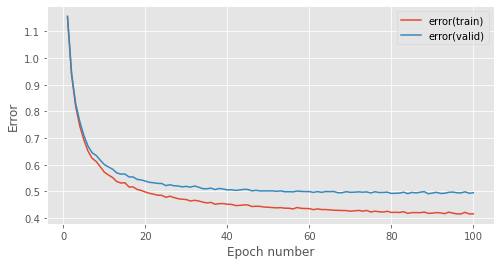

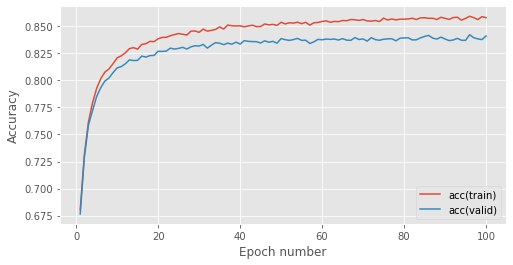

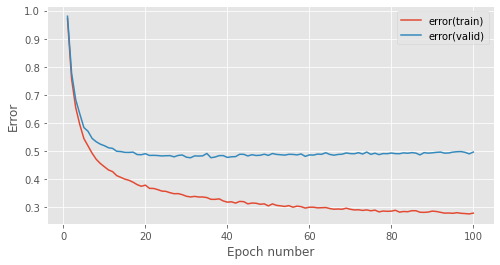

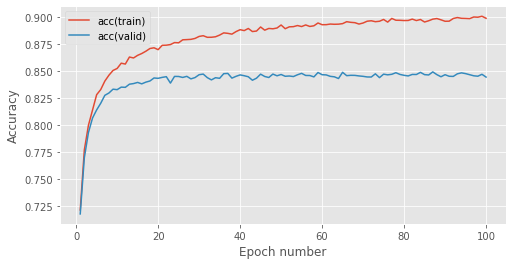

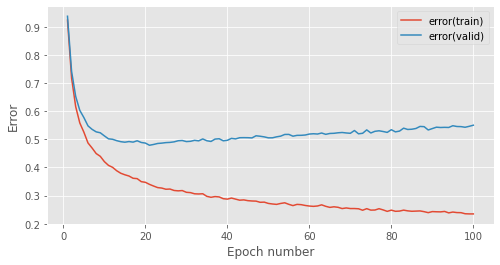

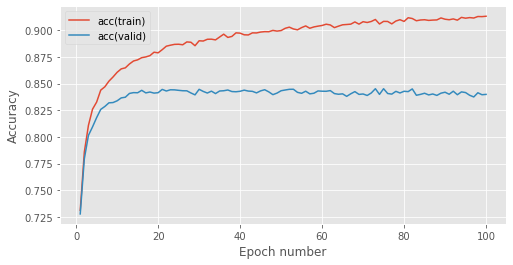

In [14]:
probs = [0.7, 0.9, 0.95]
input_dim, output_dim, hidden_dim = 784, 47, 128

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for incl_prob in probs:
    print("Dropout prob: " + str(incl_prob))
    model = MultipleLayerModel([
        DropoutLayer(rng, incl_prob),
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "q3-dropout-prob-" + str(incl_prob))

### Weight Penalty

In [9]:
%run ./DropoutandPenalty_tests.ipynb

Dropout Layer Fprop Functionality Test Passed
Dropout Layer Bprop Test Passed
L1 Penalty Call Functionality Test Passed
L1 Penalty Grad Function Test Passed
L2 Penalty Call Functionality Test Passed
L2 Penalty Grad Function Test Passed


In [8]:
from mlp.penalties import L1Penalty, L2Penalty

#### L1Penalty

L1Penalty coeff: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.11e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 3.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 3.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 3.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 3.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.03e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 3.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 3.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.19e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 3.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 3.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.09e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.23e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 3.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.07e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 3.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 3.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 3.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Finished model accuracy
Train acc: 0.02174999999999994
Val acc: 0.019810126582278445

Finished model error
Train err: 3.8501229399603702
Val err: 3.8504528146212467

L1Penalty coeff: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 3.1s to complete
    error(train)=1.43e+00, acc(train)=6.25e-01, error(valid)=1.43e+00, acc(valid)=6.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 3.0s to complete
    error(train)=1.33e+00, acc(train)=6.42e-01, error(valid)=1.34e+00, acc(valid)=6.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.9s to complete
    error(train)=1.28e+00, acc(train)=6.58e-01, error(valid)=1.28e+00, acc(valid)=6.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 3.1s to complete
    error(train)=1.25e+00, acc(train)=6.60e-01, error(valid)=1.25e+00, acc(valid)=6.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.9s to complete
    error(train)=1.24e+00, acc(train)=6.62e-01, error(valid)=1.24e+00, acc(valid)=6.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.9s to complete
    error(train)=1.21e+00, acc(train)=6.70e-01, error(valid)=1.21e+00, acc(valid)=6.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 3.2s to complete
    error(train)=1.20e+00, acc(train)=6.71e-01, error(valid)=1.21e+00, acc(valid)=6.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.9s to complete
    error(train)=1.19e+00, acc(train)=6.73e-01, error(valid)=1.19e+00, acc(valid)=6.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.9s to complete
    error(train)=1.19e+00, acc(train)=6.73e-01, error(valid)=1.19e+00, acc(valid)=6.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 3.0s to complete
    error(train)=1.17e+00, acc(train)=6.80e-01, error(valid)=1.17e+00, acc(valid)=6.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.8s to complete
    error(train)=1.16e+00, acc(train)=6.81e-01, error(valid)=1.17e+00, acc(valid)=6.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.8s to complete
    error(train)=1.16e+00, acc(train)=6.82e-01, error(valid)=1.17e+00, acc(valid)=6.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.9s to complete
    error(train)=1.16e+00, acc(train)=6.82e-01, error(valid)=1.16e+00, acc(valid)=6.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.8s to complete
    error(train)=1.15e+00, acc(train)=6.83e-01, error(valid)=1.16e+00, acc(valid)=6.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.8s to complete
    error(train)=1.14e+00, acc(train)=6.85e-01, error(valid)=1.15e+00, acc(valid)=6.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 3.1s to complete
    error(train)=1.14e+00, acc(train)=6.87e-01, error(valid)=1.15e+00, acc(valid)=6.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.8s to complete
    error(train)=1.14e+00, acc(train)=6.85e-01, error(valid)=1.14e+00, acc(valid)=6.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 3.0s to complete
    error(train)=1.13e+00, acc(train)=6.89e-01, error(valid)=1.14e+00, acc(valid)=6.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.9s to complete
    error(train)=1.13e+00, acc(train)=6.90e-01, error(valid)=1.14e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.8s to complete
    error(train)=1.13e+00, acc(train)=6.90e-01, error(valid)=1.14e+00, acc(valid)=6.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.9s to complete
    error(train)=1.13e+00, acc(train)=6.90e-01, error(valid)=1.13e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 3.0s to complete
    error(train)=1.13e+00, acc(train)=6.87e-01, error(valid)=1.14e+00, acc(valid)=6.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 3.2s to complete
    error(train)=1.12e+00, acc(train)=6.91e-01, error(valid)=1.13e+00, acc(valid)=6.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 3.2s to complete
    error(train)=1.12e+00, acc(train)=6.91e-01, error(valid)=1.12e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 3.0s to complete
    error(train)=1.12e+00, acc(train)=6.92e-01, error(valid)=1.13e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.9s to complete
    error(train)=1.11e+00, acc(train)=6.92e-01, error(valid)=1.12e+00, acc(valid)=6.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.93e-01, error(valid)=1.12e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.93e-01, error(valid)=1.12e+00, acc(valid)=6.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.91e-01, error(valid)=1.12e+00, acc(valid)=6.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.94e-01, error(valid)=1.12e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.96e-01, error(valid)=1.12e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.9s to complete
    error(train)=1.11e+00, acc(train)=6.94e-01, error(valid)=1.11e+00, acc(valid)=6.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.9s to complete
    error(train)=1.11e+00, acc(train)=6.92e-01, error(valid)=1.12e+00, acc(valid)=6.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.93e-01, error(valid)=1.12e+00, acc(valid)=6.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 3.0s to complete
    error(train)=1.11e+00, acc(train)=6.93e-01, error(valid)=1.12e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.92e-01, error(valid)=1.11e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 3.2s to complete
    error(train)=1.11e+00, acc(train)=6.94e-01, error(valid)=1.11e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 3.0s to complete
    error(train)=1.10e+00, acc(train)=6.92e-01, error(valid)=1.11e+00, acc(valid)=6.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.9s to complete
    error(train)=1.11e+00, acc(train)=6.92e-01, error(valid)=1.12e+00, acc(valid)=6.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 3.1s to complete
    error(train)=1.11e+00, acc(train)=6.91e-01, error(valid)=1.12e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 3.0s to complete
    error(train)=1.11e+00, acc(train)=6.91e-01, error(valid)=1.12e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.9s to complete
    error(train)=1.10e+00, acc(train)=6.96e-01, error(valid)=1.11e+00, acc(valid)=6.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 3.0s to complete
    error(train)=1.11e+00, acc(train)=6.91e-01, error(valid)=1.12e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 3.2s to complete
    error(train)=1.10e+00, acc(train)=6.97e-01, error(valid)=1.10e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 3.1s to complete
    error(train)=1.10e+00, acc(train)=6.94e-01, error(valid)=1.11e+00, acc(valid)=6.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.8s to complete
    error(train)=1.11e+00, acc(train)=6.91e-01, error(valid)=1.12e+00, acc(valid)=6.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 3.0s to complete
    error(train)=1.10e+00, acc(train)=6.96e-01, error(valid)=1.10e+00, acc(valid)=6.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 3.2s to complete
    error(train)=1.10e+00, acc(train)=6.93e-01, error(valid)=1.11e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 3.0s to complete
    error(train)=1.10e+00, acc(train)=6.94e-01, error(valid)=1.11e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 3.2s to complete
    error(train)=1.09e+00, acc(train)=6.98e-01, error(valid)=1.10e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 3.4s to complete
    error(train)=1.10e+00, acc(train)=6.97e-01, error(valid)=1.10e+00, acc(valid)=6.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 3.2s to complete
    error(train)=1.09e+00, acc(train)=6.97e-01, error(valid)=1.10e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 3.1s to complete
    error(train)=1.10e+00, acc(train)=6.96e-01, error(valid)=1.11e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.8s to complete
    error(train)=1.10e+00, acc(train)=6.96e-01, error(valid)=1.10e+00, acc(valid)=6.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.96e-01, error(valid)=1.10e+00, acc(valid)=6.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.9s to complete
    error(train)=1.10e+00, acc(train)=6.96e-01, error(valid)=1.11e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.98e-01, error(valid)=1.10e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.97e-01, error(valid)=1.09e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.97e-01, error(valid)=1.10e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.8s to complete
    error(train)=1.09e+00, acc(train)=6.98e-01, error(valid)=1.10e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.9s to complete
    error(train)=1.09e+00, acc(train)=6.95e-01, error(valid)=1.10e+00, acc(valid)=6.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.98e-01, error(valid)=1.10e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.98e-01, error(valid)=1.09e+00, acc(valid)=6.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 3.1s to complete
    error(train)=1.09e+00, acc(train)=7.00e-01, error(valid)=1.09e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 3.1s to complete
    error(train)=1.09e+00, acc(train)=6.99e-01, error(valid)=1.09e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.98e-01, error(valid)=1.09e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 3.0s to complete
    error(train)=1.08e+00, acc(train)=7.01e-01, error(valid)=1.09e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 3.2s to complete
    error(train)=1.09e+00, acc(train)=6.95e-01, error(valid)=1.10e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.9s to complete
    error(train)=1.09e+00, acc(train)=6.97e-01, error(valid)=1.10e+00, acc(valid)=6.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 3.0s to complete
    error(train)=1.09e+00, acc(train)=6.98e-01, error(valid)=1.09e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.8s to complete
    error(train)=1.08e+00, acc(train)=7.00e-01, error(valid)=1.09e+00, acc(valid)=6.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.9s to complete
    error(train)=1.08e+00, acc(train)=7.00e-01, error(valid)=1.09e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.8s to complete
    error(train)=1.08e+00, acc(train)=7.02e-01, error(valid)=1.08e+00, acc(valid)=6.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.8s to complete
    error(train)=1.08e+00, acc(train)=6.99e-01, error(valid)=1.09e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.9s to complete
    error(train)=1.08e+00, acc(train)=6.99e-01, error(valid)=1.09e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 3.0s to complete
    error(train)=1.08e+00, acc(train)=7.00e-01, error(valid)=1.09e+00, acc(valid)=6.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.9s to complete
    error(train)=1.08e+00, acc(train)=6.98e-01, error(valid)=1.09e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 3.0s to complete
    error(train)=1.08e+00, acc(train)=7.01e-01, error(valid)=1.09e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 3.1s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.08e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 3.1s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.08e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 3.2s to complete
    error(train)=1.08e+00, acc(train)=6.98e-01, error(valid)=1.09e+00, acc(valid)=6.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 3.4s to complete
    error(train)=1.07e+00, acc(train)=7.04e-01, error(valid)=1.08e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 3.3s to complete
    error(train)=1.07e+00, acc(train)=7.01e-01, error(valid)=1.08e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 3.1s to complete
    error(train)=1.08e+00, acc(train)=7.00e-01, error(valid)=1.08e+00, acc(valid)=6.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.9s to complete
    error(train)=1.08e+00, acc(train)=7.01e-01, error(valid)=1.09e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.8s to complete
    error(train)=1.07e+00, acc(train)=7.00e-01, error(valid)=1.08e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.9s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.07e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.8s to complete
    error(train)=1.07e+00, acc(train)=7.04e-01, error(valid)=1.08e+00, acc(valid)=7.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.8s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.08e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.8s to complete
    error(train)=1.06e+00, acc(train)=7.05e-01, error(valid)=1.07e+00, acc(valid)=7.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 3.0s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.07e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 3.0s to complete
    error(train)=1.07e+00, acc(train)=7.02e-01, error(valid)=1.08e+00, acc(valid)=6.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.8s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.08e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 3.2s to complete
    error(train)=1.07e+00, acc(train)=7.02e-01, error(valid)=1.08e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.8s to complete
    error(train)=1.06e+00, acc(train)=7.05e-01, error(valid)=1.07e+00, acc(valid)=7.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 3.0s to complete
    error(train)=1.06e+00, acc(train)=7.06e-01, error(valid)=1.07e+00, acc(valid)=7.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 3.1s to complete
    error(train)=1.06e+00, acc(train)=7.04e-01, error(valid)=1.07e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.9s to complete
    error(train)=1.07e+00, acc(train)=7.02e-01, error(valid)=1.08e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.9s to complete
    error(train)=1.06e+00, acc(train)=7.04e-01, error(valid)=1.07e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.9s to complete
    error(train)=1.07e+00, acc(train)=7.04e-01, error(valid)=1.08e+00, acc(valid)=7.00e-01


Finished model accuracy
Train acc: 0.7039100000000006
Val acc: 0.700126582278481

Finished model error
Train err: 1.0700701482815895
Val err: 1.0786658660194581

L1Penalty coeff: 0.0001


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 3.0s to complete
    error(train)=9.90e-01, acc(train)=7.20e-01, error(valid)=1.00e+00, acc(valid)=7.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.9s to complete
    error(train)=8.01e-01, acc(train)=7.67e-01, error(valid)=8.23e-01, acc(valid)=7.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.9s to complete
    error(train)=7.13e-01, acc(train)=7.89e-01, error(valid)=7.40e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.8s to complete
    error(train)=6.54e-01, acc(train)=8.04e-01, error(valid)=6.79e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.8s to complete
    error(train)=6.18e-01, acc(train)=8.12e-01, error(valid)=6.47e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.8s to complete
    error(train)=5.99e-01, acc(train)=8.15e-01, error(valid)=6.28e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.8s to complete
    error(train)=5.66e-01, acc(train)=8.26e-01, error(valid)=5.98e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.8s to complete
    error(train)=5.61e-01, acc(train)=8.26e-01, error(valid)=5.92e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 3.1s to complete
    error(train)=5.43e-01, acc(train)=8.31e-01, error(valid)=5.78e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 3.2s to complete
    error(train)=5.33e-01, acc(train)=8.33e-01, error(valid)=5.68e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 3.2s to complete
    error(train)=5.25e-01, acc(train)=8.36e-01, error(valid)=5.62e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.8s to complete
    error(train)=5.21e-01, acc(train)=8.35e-01, error(valid)=5.59e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 3.0s to complete
    error(train)=5.14e-01, acc(train)=8.35e-01, error(valid)=5.52e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 3.5s to complete
    error(train)=5.06e-01, acc(train)=8.38e-01, error(valid)=5.46e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.9s to complete
    error(train)=5.01e-01, acc(train)=8.41e-01, error(valid)=5.40e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 3.0s to complete
    error(train)=4.99e-01, acc(train)=8.41e-01, error(valid)=5.40e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 3.4s to complete
    error(train)=4.90e-01, acc(train)=8.43e-01, error(valid)=5.30e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 3.1s to complete
    error(train)=4.92e-01, acc(train)=8.43e-01, error(valid)=5.33e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 3.0s to complete
    error(train)=4.88e-01, acc(train)=8.44e-01, error(valid)=5.35e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.9s to complete
    error(train)=4.83e-01, acc(train)=8.46e-01, error(valid)=5.27e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.9s to complete
    error(train)=4.77e-01, acc(train)=8.48e-01, error(valid)=5.24e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.9s to complete
    error(train)=4.81e-01, acc(train)=8.46e-01, error(valid)=5.24e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 3.0s to complete
    error(train)=4.73e-01, acc(train)=8.48e-01, error(valid)=5.20e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.8s to complete
    error(train)=4.71e-01, acc(train)=8.49e-01, error(valid)=5.18e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.9s to complete
    error(train)=4.67e-01, acc(train)=8.49e-01, error(valid)=5.13e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 3.0s to complete
    error(train)=4.66e-01, acc(train)=8.51e-01, error(valid)=5.18e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.9s to complete
    error(train)=4.61e-01, acc(train)=8.51e-01, error(valid)=5.10e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.9s to complete
    error(train)=4.64e-01, acc(train)=8.51e-01, error(valid)=5.14e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.8s to complete
    error(train)=4.61e-01, acc(train)=8.51e-01, error(valid)=5.13e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.9s to complete
    error(train)=4.59e-01, acc(train)=8.52e-01, error(valid)=5.11e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 3.3s to complete
    error(train)=4.61e-01, acc(train)=8.52e-01, error(valid)=5.12e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 3.2s to complete
    error(train)=4.66e-01, acc(train)=8.47e-01, error(valid)=5.17e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.9s to complete
    error(train)=4.63e-01, acc(train)=8.51e-01, error(valid)=5.13e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.9s to complete
    error(train)=4.55e-01, acc(train)=8.53e-01, error(valid)=5.07e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.9s to complete
    error(train)=4.55e-01, acc(train)=8.53e-01, error(valid)=5.08e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.9s to complete
    error(train)=4.53e-01, acc(train)=8.54e-01, error(valid)=5.08e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 3.1s to complete
    error(train)=4.56e-01, acc(train)=8.53e-01, error(valid)=5.07e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 3.4s to complete
    error(train)=4.54e-01, acc(train)=8.53e-01, error(valid)=5.06e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 3.0s to complete
    error(train)=4.50e-01, acc(train)=8.54e-01, error(valid)=5.03e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 3.1s to complete
    error(train)=4.48e-01, acc(train)=8.55e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 3.0s to complete
    error(train)=4.48e-01, acc(train)=8.54e-01, error(valid)=5.02e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 3.1s to complete
    error(train)=4.48e-01, acc(train)=8.55e-01, error(valid)=5.05e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 3.1s to complete
    error(train)=4.54e-01, acc(train)=8.52e-01, error(valid)=5.07e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 3.3s to complete
    error(train)=4.52e-01, acc(train)=8.54e-01, error(valid)=5.01e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 3.2s to complete
    error(train)=4.49e-01, acc(train)=8.56e-01, error(valid)=5.07e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 3.6s to complete
    error(train)=4.46e-01, acc(train)=8.56e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 3.3s to complete
    error(train)=4.50e-01, acc(train)=8.55e-01, error(valid)=5.06e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.9s to complete
    error(train)=4.51e-01, acc(train)=8.52e-01, error(valid)=5.11e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 3.0s to complete
    error(train)=4.47e-01, acc(train)=8.54e-01, error(valid)=5.03e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 3.0s to complete
    error(train)=4.53e-01, acc(train)=8.54e-01, error(valid)=5.07e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.9s to complete
    error(train)=4.43e-01, acc(train)=8.56e-01, error(valid)=5.01e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.9s to complete
    error(train)=4.37e-01, acc(train)=8.59e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.9s to complete
    error(train)=4.39e-01, acc(train)=8.57e-01, error(valid)=4.93e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.8s to complete
    error(train)=4.43e-01, acc(train)=8.55e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 3.4s to complete
    error(train)=4.41e-01, acc(train)=8.58e-01, error(valid)=4.96e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 3.2s to complete
    error(train)=4.44e-01, acc(train)=8.55e-01, error(valid)=5.02e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 3.1s to complete
    error(train)=4.41e-01, acc(train)=8.58e-01, error(valid)=4.98e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 3.2s to complete
    error(train)=4.42e-01, acc(train)=8.56e-01, error(valid)=4.99e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 3.1s to complete
    error(train)=4.39e-01, acc(train)=8.56e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 3.2s to complete
    error(train)=4.39e-01, acc(train)=8.58e-01, error(valid)=4.98e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 3.4s to complete
    error(train)=4.36e-01, acc(train)=8.59e-01, error(valid)=4.94e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 3.2s to complete
    error(train)=4.42e-01, acc(train)=8.56e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.9s to complete
    error(train)=4.33e-01, acc(train)=8.59e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.9s to complete
    error(train)=4.34e-01, acc(train)=8.59e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.8s to complete
    error(train)=4.38e-01, acc(train)=8.56e-01, error(valid)=4.97e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.9s to complete
    error(train)=4.38e-01, acc(train)=8.58e-01, error(valid)=4.98e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.9s to complete
    error(train)=4.40e-01, acc(train)=8.57e-01, error(valid)=4.93e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.9s to complete
    error(train)=4.36e-01, acc(train)=8.56e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.9s to complete
    error(train)=4.40e-01, acc(train)=8.56e-01, error(valid)=4.97e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 3.2s to complete
    error(train)=4.32e-01, acc(train)=8.58e-01, error(valid)=4.90e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 3.4s to complete
    error(train)=4.34e-01, acc(train)=8.59e-01, error(valid)=4.93e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.9s to complete
    error(train)=4.36e-01, acc(train)=8.57e-01, error(valid)=4.94e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.9s to complete
    error(train)=4.38e-01, acc(train)=8.57e-01, error(valid)=4.96e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.9s to complete
    error(train)=4.34e-01, acc(train)=8.58e-01, error(valid)=4.93e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 3.5s to complete
    error(train)=4.37e-01, acc(train)=8.58e-01, error(valid)=4.95e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 3.1s to complete
    error(train)=4.37e-01, acc(train)=8.58e-01, error(valid)=4.96e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 3.1s to complete
    error(train)=4.32e-01, acc(train)=8.59e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 3.2s to complete
    error(train)=4.35e-01, acc(train)=8.58e-01, error(valid)=4.95e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.9s to complete
    error(train)=4.33e-01, acc(train)=8.59e-01, error(valid)=4.90e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.9s to complete
    error(train)=4.29e-01, acc(train)=8.60e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.9s to complete
    error(train)=4.32e-01, acc(train)=8.59e-01, error(valid)=4.92e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 3.1s to complete
    error(train)=4.34e-01, acc(train)=8.59e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 3.1s to complete
    error(train)=4.37e-01, acc(train)=8.57e-01, error(valid)=4.97e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 3.2s to complete
    error(train)=4.36e-01, acc(train)=8.55e-01, error(valid)=4.97e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 3.1s to complete
    error(train)=4.34e-01, acc(train)=8.58e-01, error(valid)=4.93e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 3.1s to complete
    error(train)=4.37e-01, acc(train)=8.58e-01, error(valid)=4.99e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.9s to complete
    error(train)=4.24e-01, acc(train)=8.61e-01, error(valid)=4.80e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 3.0s to complete
    error(train)=4.30e-01, acc(train)=8.60e-01, error(valid)=4.88e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.9s to complete
    error(train)=4.33e-01, acc(train)=8.59e-01, error(valid)=4.92e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 3.4s to complete
    error(train)=4.40e-01, acc(train)=8.55e-01, error(valid)=5.02e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 3.0s to complete
    error(train)=4.32e-01, acc(train)=8.60e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 3.0s to complete
    error(train)=4.27e-01, acc(train)=8.62e-01, error(valid)=4.87e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 3.4s to complete
    error(train)=4.30e-01, acc(train)=8.60e-01, error(valid)=4.92e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 3.2s to complete
    error(train)=4.33e-01, acc(train)=8.58e-01, error(valid)=4.93e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 3.0s to complete
    error(train)=4.29e-01, acc(train)=8.60e-01, error(valid)=4.89e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.9s to complete
    error(train)=4.29e-01, acc(train)=8.60e-01, error(valid)=4.89e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 3.3s to complete
    error(train)=4.32e-01, acc(train)=8.58e-01, error(valid)=4.94e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.9s to complete
    error(train)=4.29e-01, acc(train)=8.60e-01, error(valid)=4.86e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 3.0s to complete
    error(train)=4.32e-01, acc(train)=8.57e-01, error(valid)=4.92e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 3.4s to complete
    error(train)=4.25e-01, acc(train)=8.60e-01, error(valid)=4.86e-01, acc(valid)=8.42e-01


Finished model accuracy
Train acc: 0.8596400000000007
Val acc: 0.8422151898734174

Finished model error
Train err: 0.4253157794709115
Val err: 0.486430133490929



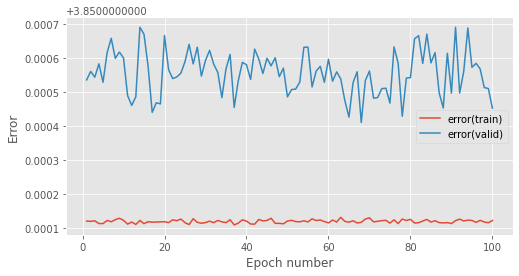

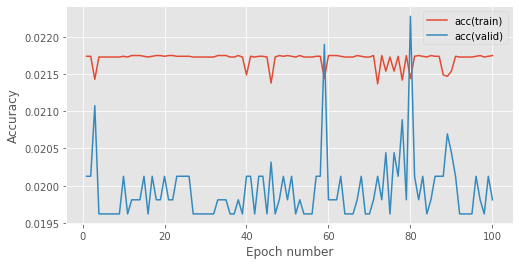

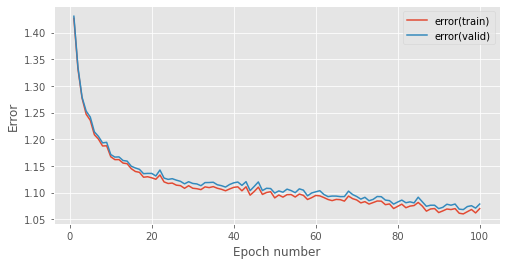

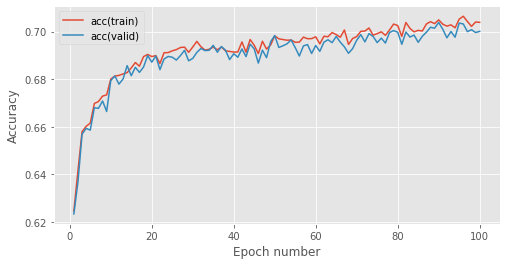

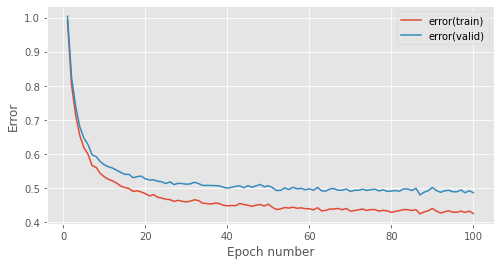

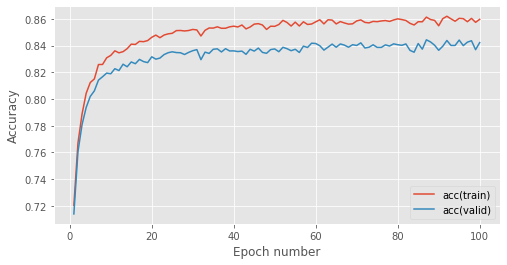

In [57]:
coeffs = [1e-1, 1e-3, 1e-4]
input_dim, output_dim, hidden_dim = 784, 47, 128

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for coeff in coeffs:
    print("L1Penalty coeff: " + str(coeff))
    weights_penalty = L1Penalty(coeff)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=weights_penalty), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=weights_penalty) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "q3-penalty-L1-coeff-" + str(coeff))

#### L2Penalty

L2Penalty coeff: 0.0001


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.2s to complete
    error(train)=8.99e-01, acc(train)=7.40e-01, error(valid)=9.19e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.1s to complete
    error(train)=7.07e-01, acc(train)=7.88e-01, error(valid)=7.39e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.0s to complete
    error(train)=6.10e-01, acc(train)=8.11e-01, error(valid)=6.58e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.2s to complete
    error(train)=5.60e-01, acc(train)=8.23e-01, error(valid)=6.12e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.1s to complete
    error(train)=5.17e-01, acc(train)=8.34e-01, error(valid)=5.79e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.2s to complete
    error(train)=4.87e-01, acc(train)=8.43e-01, error(valid)=5.59e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.3s to complete
    error(train)=4.79e-01, acc(train)=8.43e-01, error(valid)=5.61e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.2s to complete
    error(train)=4.59e-01, acc(train)=8.48e-01, error(valid)=5.48e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.7s to complete
    error(train)=4.47e-01, acc(train)=8.52e-01, error(valid)=5.40e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.2s to complete
    error(train)=4.28e-01, acc(train)=8.58e-01, error(valid)=5.20e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.2s to complete
    error(train)=4.15e-01, acc(train)=8.62e-01, error(valid)=5.17e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.2s to complete
    error(train)=4.08e-01, acc(train)=8.65e-01, error(valid)=5.16e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.3s to complete
    error(train)=3.98e-01, acc(train)=8.66e-01, error(valid)=5.10e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 6.9s to complete
    error(train)=3.97e-01, acc(train)=8.65e-01, error(valid)=5.16e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 8.4s to complete
    error(train)=4.00e-01, acc(train)=8.61e-01, error(valid)=5.22e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 8.3s to complete
    error(train)=3.76e-01, acc(train)=8.72e-01, error(valid)=5.04e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 8.4s to complete
    error(train)=3.82e-01, acc(train)=8.71e-01, error(valid)=5.16e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 8.4s to complete
    error(train)=3.72e-01, acc(train)=8.72e-01, error(valid)=5.06e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 8.6s to complete
    error(train)=3.68e-01, acc(train)=8.73e-01, error(valid)=5.10e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 8.7s to complete
    error(train)=3.59e-01, acc(train)=8.78e-01, error(valid)=5.01e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 9.1s to complete
    error(train)=3.66e-01, acc(train)=8.73e-01, error(valid)=5.13e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 9.2s to complete
    error(train)=3.49e-01, acc(train)=8.80e-01, error(valid)=4.99e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 9.2s to complete
    error(train)=3.49e-01, acc(train)=8.80e-01, error(valid)=5.05e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 9.5s to complete
    error(train)=3.43e-01, acc(train)=8.83e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 9.6s to complete
    error(train)=3.42e-01, acc(train)=8.82e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 9.6s to complete
    error(train)=3.45e-01, acc(train)=8.81e-01, error(valid)=5.07e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 9.9s to complete
    error(train)=3.36e-01, acc(train)=8.85e-01, error(valid)=5.01e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 9.6s to complete
    error(train)=3.28e-01, acc(train)=8.87e-01, error(valid)=4.94e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 9.7s to complete
    error(train)=3.39e-01, acc(train)=8.82e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 9.6s to complete
    error(train)=3.28e-01, acc(train)=8.86e-01, error(valid)=5.01e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 9.6s to complete
    error(train)=3.29e-01, acc(train)=8.87e-01, error(valid)=5.03e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 9.4s to complete
    error(train)=3.22e-01, acc(train)=8.89e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 9.3s to complete
    error(train)=3.27e-01, acc(train)=8.83e-01, error(valid)=5.06e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 9.3s to complete
    error(train)=3.13e-01, acc(train)=8.92e-01, error(valid)=4.91e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 9.6s to complete
    error(train)=3.28e-01, acc(train)=8.87e-01, error(valid)=5.07e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 9.2s to complete
    error(train)=3.20e-01, acc(train)=8.87e-01, error(valid)=5.02e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 9.6s to complete
    error(train)=3.21e-01, acc(train)=8.88e-01, error(valid)=5.08e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 9.4s to complete
    error(train)=3.12e-01, acc(train)=8.91e-01, error(valid)=4.97e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 9.4s to complete
    error(train)=3.21e-01, acc(train)=8.88e-01, error(valid)=5.07e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 9.3s to complete
    error(train)=3.04e-01, acc(train)=8.94e-01, error(valid)=4.94e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 9.4s to complete
    error(train)=3.07e-01, acc(train)=8.94e-01, error(valid)=4.98e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 9.1s to complete
    error(train)=3.04e-01, acc(train)=8.94e-01, error(valid)=5.00e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 9.3s to complete
    error(train)=3.06e-01, acc(train)=8.93e-01, error(valid)=4.98e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 9.2s to complete
    error(train)=3.07e-01, acc(train)=8.92e-01, error(valid)=5.01e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 9.3s to complete
    error(train)=3.08e-01, acc(train)=8.92e-01, error(valid)=5.03e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 9.5s to complete
    error(train)=3.04e-01, acc(train)=8.93e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 10.2s to complete
    error(train)=3.03e-01, acc(train)=8.93e-01, error(valid)=5.06e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 10.0s to complete
    error(train)=2.98e-01, acc(train)=8.96e-01, error(valid)=4.98e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 9.4s to complete
    error(train)=2.96e-01, acc(train)=8.97e-01, error(valid)=4.95e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 9.8s to complete
    error(train)=3.03e-01, acc(train)=8.93e-01, error(valid)=5.08e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 9.4s to complete
    error(train)=2.98e-01, acc(train)=8.96e-01, error(valid)=5.05e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 9.2s to complete
    error(train)=2.90e-01, acc(train)=8.99e-01, error(valid)=4.98e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 9.4s to complete
    error(train)=2.93e-01, acc(train)=8.97e-01, error(valid)=5.01e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 9.8s to complete
    error(train)=2.91e-01, acc(train)=8.98e-01, error(valid)=5.06e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 10.4s to complete
    error(train)=2.94e-01, acc(train)=8.97e-01, error(valid)=5.06e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 10.4s to complete
    error(train)=2.91e-01, acc(train)=8.99e-01, error(valid)=5.07e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 9.7s to complete
    error(train)=2.95e-01, acc(train)=8.96e-01, error(valid)=5.06e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 9.6s to complete
    error(train)=2.92e-01, acc(train)=8.97e-01, error(valid)=5.11e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 9.3s to complete
    error(train)=2.86e-01, acc(train)=9.00e-01, error(valid)=5.04e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 9.2s to complete
    error(train)=2.87e-01, acc(train)=8.99e-01, error(valid)=5.04e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 9.6s to complete
    error(train)=2.84e-01, acc(train)=9.00e-01, error(valid)=5.05e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 9.9s to complete
    error(train)=2.91e-01, acc(train)=8.96e-01, error(valid)=5.12e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 9.7s to complete
    error(train)=2.83e-01, acc(train)=9.01e-01, error(valid)=4.98e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 9.7s to complete
    error(train)=2.90e-01, acc(train)=8.97e-01, error(valid)=5.09e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 9.7s to complete
    error(train)=2.93e-01, acc(train)=8.96e-01, error(valid)=5.17e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 9.5s to complete
    error(train)=2.85e-01, acc(train)=8.99e-01, error(valid)=5.09e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 10.1s to complete
    error(train)=2.82e-01, acc(train)=9.00e-01, error(valid)=5.04e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 9.5s to complete
    error(train)=2.78e-01, acc(train)=9.02e-01, error(valid)=5.04e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 9.5s to complete
    error(train)=2.89e-01, acc(train)=8.96e-01, error(valid)=5.17e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 9.6s to complete
    error(train)=2.92e-01, acc(train)=8.95e-01, error(valid)=5.19e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 9.6s to complete
    error(train)=2.84e-01, acc(train)=8.98e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 9.5s to complete
    error(train)=2.92e-01, acc(train)=8.96e-01, error(valid)=5.21e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 9.5s to complete
    error(train)=2.83e-01, acc(train)=9.00e-01, error(valid)=5.11e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 9.1s to complete
    error(train)=2.80e-01, acc(train)=9.01e-01, error(valid)=5.11e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 9.4s to complete
    error(train)=2.79e-01, acc(train)=9.01e-01, error(valid)=5.12e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 9.9s to complete
    error(train)=2.79e-01, acc(train)=9.01e-01, error(valid)=5.12e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 9.3s to complete
    error(train)=2.78e-01, acc(train)=9.01e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 9.6s to complete
    error(train)=2.89e-01, acc(train)=8.96e-01, error(valid)=5.17e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 9.5s to complete
    error(train)=2.89e-01, acc(train)=8.98e-01, error(valid)=5.15e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 9.2s to complete
    error(train)=2.80e-01, acc(train)=9.01e-01, error(valid)=5.13e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 10.0s to complete
    error(train)=2.79e-01, acc(train)=9.00e-01, error(valid)=5.15e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 9.9s to complete
    error(train)=2.75e-01, acc(train)=9.02e-01, error(valid)=5.10e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 9.7s to complete
    error(train)=2.81e-01, acc(train)=9.00e-01, error(valid)=5.14e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 9.4s to complete
    error(train)=2.78e-01, acc(train)=9.03e-01, error(valid)=5.19e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 9.6s to complete
    error(train)=2.76e-01, acc(train)=9.03e-01, error(valid)=5.13e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 9.5s to complete
    error(train)=2.80e-01, acc(train)=9.01e-01, error(valid)=5.14e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 9.6s to complete
    error(train)=2.82e-01, acc(train)=8.99e-01, error(valid)=5.20e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 9.5s to complete
    error(train)=2.63e-01, acc(train)=9.08e-01, error(valid)=5.04e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 9.8s to complete
    error(train)=2.74e-01, acc(train)=9.02e-01, error(valid)=5.14e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 9.5s to complete
    error(train)=2.78e-01, acc(train)=9.03e-01, error(valid)=5.13e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 10.4s to complete
    error(train)=2.77e-01, acc(train)=9.02e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 9.6s to complete
    error(train)=2.73e-01, acc(train)=9.03e-01, error(valid)=5.09e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 10.1s to complete
    error(train)=2.69e-01, acc(train)=9.04e-01, error(valid)=5.06e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 9.4s to complete
    error(train)=2.66e-01, acc(train)=9.06e-01, error(valid)=5.07e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 9.1s to complete
    error(train)=2.67e-01, acc(train)=9.07e-01, error(valid)=5.08e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 9.1s to complete
    error(train)=2.77e-01, acc(train)=9.01e-01, error(valid)=5.16e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 9.1s to complete
    error(train)=2.75e-01, acc(train)=9.01e-01, error(valid)=5.17e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 9.6s to complete
    error(train)=2.82e-01, acc(train)=8.98e-01, error(valid)=5.24e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 9.4s to complete
    error(train)=2.74e-01, acc(train)=9.03e-01, error(valid)=5.14e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 9.0s to complete
    error(train)=2.73e-01, acc(train)=9.01e-01, error(valid)=5.16e-01, acc(valid)=8.35e-01


Finished model accuracy
Train acc: 0.9014799999999952
Val acc: 0.8345569620253162

Finished model error
Train err: 0.2734909979237136
Val err: 0.5157110174507541



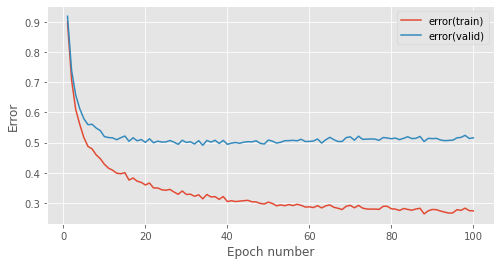

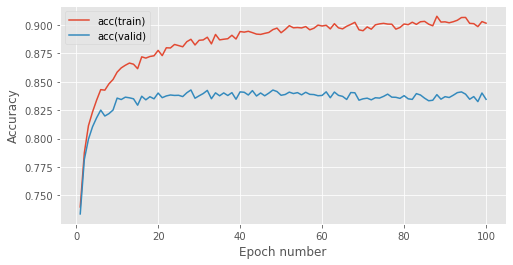

In [12]:
coeffs = [1e-4]#[1e-1, 1e-3, 1e-4]
input_dim, output_dim, hidden_dim = 784, 47, 128

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for coeff in coeffs:
    print("L2Penalty coeff: " + str(coeff))
    weights_penalty = L2Penalty(coeff)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=weights_penalty), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=weights_penalty) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "q3-penalty-L2-coeff-" + str(coeff))

## Question Figure 3

/home/hwixley/Documents/4th-Year/MLP/MLP-Coursework1/notebooks/results/q2/q2-1layer-128units


Text(0, 0.5, 'Accuracy')

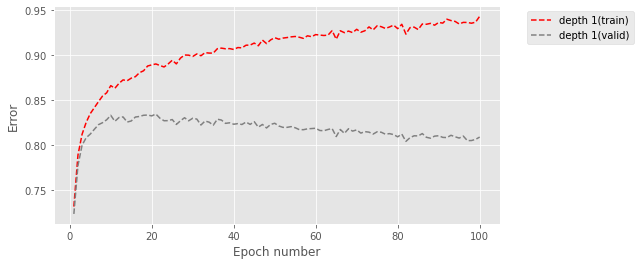

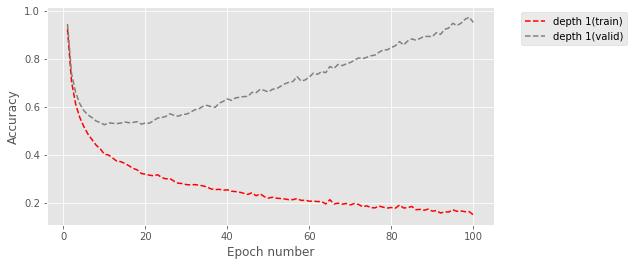

In [46]:
depth_dir = os.getcwd() + "/results/q2/"
names = ["q2-1layer-128units", "q2-2layers-128units", "q2-3layers-128units"]
colours = ["red", "blue", "purple", "grey", "yellow", "green"]
dataset = ["train", "valid"]
lsty = "dashed"

#ERROR
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)

#ACCURACY
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)

for i in range(1):
    print(depth_dir + names[i])
    stats = np.load(depth_dir + names[i] + "-stats.npy")
    #keys = np.load(depth_dir + names[i] + "-keys.npy", allow_pickle=True)
    
    for a in range(2):
        k = 1 + a*2
        plt_label = "depth " + str(i+1) +  "(" + dataset[a] + ")"
        c = colours[a*3 + i]
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, k], label=plt_label, color=c, linestyle=lsty)
    
    for b in range(2):
        k = b*2
        plt_label = "depth " + str(i+1) +  "(" + dataset[b] + ")"
        c = colours[b*3 + i]
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, k], label=plt_label, color=c, linestyle=lsty)
    
ax_1.legend(bbox_to_anchor=(1.05, 1))
ax_1.set_xlabel('Epoch number')
ax_1.set_ylabel('Error')

ax_2.legend(bbox_to_anchor=(1.05, 1))
ax_2.set_xlabel('Epoch number')
ax_2.set_ylabel('Accuracy')

In [47]:
def plot_all_models(q_num, model_names):
    depth_dir = os.getcwd() + "/results/q" + q_num + "/q" + q_num
    colours = ["red", "blue", "purple", "grey", "yellow", "green"]
    dataset = ["train", "valid"]
    lsty = ["solid","dashed"]

    #ERROR
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)

    #ACCURACY
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)

    for i in range(3):
        stats = np.load(depth_dir + names[i] + "-stats.npy")

        for a in range(2):
            k = 1 + a*2
            plt_label = "depth " + str(i+1) +  "(" + dataset[a] + ")"
            c = colours[a*3 + i]
            ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                      stats[1:, k], label=plt_label, color=c, linestyle=lsty[a])

        for b in range(2):
            k = b*2
            plt_label = "depth " + str(i+1) +  "(" + dataset[b] + ")"
            c = colours[b*3 + i]
            ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                      stats[1:, k], label=plt_label, color=c, linestyle=lsty[b])

    ax_1.legend(bbox_to_anchor=(1.05, 1))
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Error')

    ax_2.legend(bbox_to_anchor=(1.05, 1))
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('Accuracy')

In [48]:
plot_all_models("2", ["-1layer-32units", "-1layer-64units", "-1layer-128units"])

TypeError: can only concatenate str (not "int") to str